# XGBoost to predict discharge disability: Mimic Emberson meta-analysis
Relationship between onset to thrombolysis time, and its SHAP value for a better outcome.

Using threshold models from notebook 083 (default learning rate and not hist model to stop the division on <=55 mins onset to thrombolysis time)


### Plain English summary

Use the set of six binary models trained in notebook 083 to predict whether the patient is below an mRS threshold value, using 7 features: "prior_disability", "stroke_severity", "stroke_team", "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", "precise_onset_known".

For the analysis in this notebook, take just the patients from the test set that receive thrombolysis. Create a dataframe that has this subset of patients repeated 6 times (one for each mRS threshold). Use the set of 6 binary models to populate the dataframe with the SHAP values for onset to thrombolysis time.

Fit a linear regression of SHAP value for onset to treatment time vs feature value onset to treatment time. Repeat this for 1) the whole dataset, so for the six repetitions of the patients in the test set that got thrombolysis, having a SHAP value for each of the mRS thresholds used to create a binary target value (<=0, <=1, <=2, <=3, <=4, <=5, and 2) each mRS threshold separately.

Hypothesis, if the data represents the results of the Emberson meta analysis, at t=0 should see SHAP value 0.7. Should cross no effect line (SHAP value 0) at 6.3hours (378mins). Applied cutoff at 4.5hours as that point was statistically significant.

### Model and data

Model: Set of 6 binary XGBoost classification models, predicting whether patient is at least as well as each mRS level at discharge. [trained in notebook 083]\
Target feature: At least as well as each mRS level (binary feature)\
Input features: 7 features (prior_disability, stroke_severity, stroke_team, age, onset_to_thrombolysis_time, any_afib_diagnosis, precise_onset_known)\
Kfold split: First kfold split
[SHAP values from notebook 083, and also SHAP values calculated in this notebook for setting each patient to no treatment]

### Aims


### Observations




#### Further work

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

## Import libraries

In [103]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import statsmodels.api as sm
import seaborn as sns

import pickle
import shap

from os.path import exists

import time
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

import seaborn as sns
%matplotlib inline


Report the time duration to run notebook

In [104]:
start_time = time.time()

Use just the first k-fold split, and define the target feature

In [105]:
k = 0
# Values to use as the threshold <= n in order to divide the target feature
list_binary_thresholds = [0, 1, 2, 3, 4, 5]
n_binary_models = len(list_binary_thresholds)
surrogate_time_for_no_thrombolysis = 9999

Select the features for the model

In [106]:
selected_features = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
n_features = len(selected_features)

target_feature = 'discharge_disability'
selected_features.append(target_feature)

Create dictionary storing the feature names to use in the plots

In [107]:
dict_feature_names = {}
dict_feature_names["prior_disability"] = "Prior disability (mRS)"
dict_feature_names["stroke_severity"] = "Stroke severity (NIHSS)"
dict_feature_names["stroke_team"] = "Stroke team"
dict_feature_names["age"] = "Age (years)"
dict_feature_names["onset_to_thrombolysis_time"] = "Onset to thrombolysis time (minutes)"
dict_feature_names["any_afib_diagnosis"] = "Atrial fibrilation diagnosis"
dict_feature_names["precise_onset_known"] = "Precise onset time known"
dict_feature_names['discharge_disability'] = "Discharge disabiliity (mRS)"

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [108]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_{n_features}_features_1fold_binary'
    notebook: str = '103_'

paths = Paths()

Create output folders if needed

In [109]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Import the first kfold split

In [110]:
# Read in training set, restrict to chosen features, & store
filename = os.path.join(paths.data_read_path, '03_train_0.csv')
train = pd.read_csv(filename)
train = train[selected_features]

filename = os.path.join(paths.data_read_path, '03_test_0.csv')
test = pd.read_csv(filename)
test = test[selected_features]

Store the output classes

In [111]:
class_names = train['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [112]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [113]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [114]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        train = convert_feature_to_one_hot(train, feature, prefix)
        test = convert_feature_to_one_hot(test, feature, prefix)

Feature names with one hot encoding

In [115]:
features_ohe = list(train)
features_ohe.remove("discharge_disability")
n_features_ohe = len(features_ohe)

print(f"There are {n_features} original features (before one-hot encoding)")
print(f"There are {n_features_ohe} features (after one-hot encoding)")

There are 7 original features (before one-hot encoding)
There are 124 features (after one-hot encoding)


Create function to return X and y data for train and test sets

In [116]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    Args:
        train [dataframe]: dataframe containing training instances 
        test [dataframe]: dataframe containing test instances
        target [string]: column name of the targert feature (the column to separate 
                        from the two dataframes)

    Returns:
        X_train [dataframe]: dataframe containing input features for the 
                            training instances 
        X_test [dataframe]: dataframe containing target feature for the training 
                            instances 
        y_train [dataframe]: dataframe containing input features for the 
                             training instances 
        y_test [dataframe]: dataframe containing target features for the 
                            training instances 
    """       

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Keep original y_test and y_train, then overwrite them for each binary model (using a different threshold)

In [117]:
(X_train, X_test, y_train_orig, y_test_orig) = get_x_y_data(train, test,
                                                         'discharge_disability')

## Load XGBoost model

From notebok 083, load the set of 6 binary models (each with the 7 input features), each one predicting the disability discharge using a different mRS threshold (<=0, <=1, <=2, <=3, <=4, <=5)

Same X data, set different y data depending on the threshold.

Model is not hist method (this gropued onset to treatmenr times <=55, so same as not receiving treatment (=999999))

Use just the first kfold threshold.

In [118]:
def convert_feature_to_binary(series, binary_threshold):
    result = (series <= binary_threshold) * 1
    return(result)

In [119]:
def load_xgboost(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Notify to run notebook 083 first
        print ("Run notebook 083 first, that trains the set of binary models")

    return(model)

In [120]:
def load_shap_extended(filename):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    Args:
        model [xgboost classification model object]: xgboost object
        k [integer]: kfold number
        X_train [dataframe]: training set (used as background data)
        X_test [dtaframe]: test set (to calculate the SHAP values for)

    Return:
        shap_values_extended [dictionary]: the extended shap values (contains 
                    .values, .base, and .data)
        
    """    
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load SHAP values extended
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Notify to run notebook 083 first
        print ("Run notebook 083 first, that trains the set of binary models")
            
    return(shap_values_extended)

In [121]:
def calculate_shap_extended(filename, model, X_train, X_test):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    Args:
        filename [string]: name of file containing SHAP extended data
        model [xgboost classification model object]: xgboost object
        X_train [dataframe]: training set (used as background data)
        X_test [dtaframe]: test set (to calculate the SHAP values for)

    Return:
        shap_values_extended [object]: the extended shap values (contains 
                    .values, .base, and .data)
        
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values
        
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)
            
        # Save shap values extended using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
    return(shap_values_extended)

In [122]:
# Initialise empty list
roc_auc_ovr_threshold = []
accuracy_threshold = []
error_within_one_threshold = []
feature_importance_threshold = []
y_probs_threshold = []
y_pred_threshold = []
model_threshold = []
shap_values_test_extended_threshold = []
list_shap_values_extended = []
list_shap_values_extended_no_ivt = []
y_probs_threshold_no_ivt =[]
list_shap_values_train_extended_no_ivt = []
list_shap_values_train_extended = []

# Take deep copy of X_test, setting all patients as not having treatment
X_test_not_get_ivt = X_test.copy(deep=True)
X_test_not_get_ivt["onset_to_thrombolysis_time"] = surrogate_time_for_no_thrombolysis

# Take deep copy of X_train, setting all patients as not having treatment
X_train_not_get_ivt = X_train.copy(deep=True)
X_train_not_get_ivt["onset_to_thrombolysis_time"] = surrogate_time_for_no_thrombolysis

# Loop through mRS thresholds
# Include the new binary feature we calculate (replaces the multiclass feature)
for binary_threshold in list_binary_thresholds:
    binary_target_feature = f'binary_{binary_threshold}'
    y_train = convert_feature_to_binary(y_train_orig, binary_threshold)
    y_test = convert_feature_to_binary(y_test_orig, binary_threshold)

    # Model filename
    filename = os.path.join(paths.model_save_path, 
                            ('083_xgb_7_features_5fold_binary_mrs' +
                             str(binary_threshold) + '_kfold' + str(k) + '.p'))

    model = load_xgboost(filename)

    model_threshold.append(model)

    # Get target categories from model
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_threshold.append(y_probs[:,1])

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_threshold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs[:,1], labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_threshold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_threshold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_threshold.append(error_within_one)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_threshold.append(feature_importance)

    # Load SHAP for test dataset (from notebook 083)
    shap_extended_filename = os.path.join(paths.data_save_path, 
                                      ('083_xgb_7_features_5fold_binary_mrs'
                                       + str(binary_threshold) + '_kfold' + str(k) +
                                       '_shap_values_extended.p'))

    (shap_values_test_extended) = load_shap_extended(shap_extended_filename)
    
    # Append shap values extended to list
    list_shap_values_extended.append(shap_values_test_extended)

    # set up filename for shap values for patients as if none got IVT
    shap_extended_no_ivt_filename = (
            os.path.join(paths.data_save_path, 
                         (paths.notebook + paths.model_text + 
                          '_mrs' + str(binary_threshold) + '_kfold' + str(k) +
                          '_shap_values_extended_no_ivt.p')))


    # Get (and store) Shapley values along with base and feature values
    shap_values_test_extended_no_ivt = (
             calculate_shap_extended(shap_extended_no_ivt_filename, 
                                     model, 
                                     X_train,
                                     X_test_not_get_ivt))

    list_shap_values_extended_no_ivt.append(shap_values_test_extended_no_ivt)

     # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test_not_get_ivt)
    y_probs_threshold_no_ivt.append(y_probs[:,1])


Check the waterfall plots for these patients, and get the prediction for it not have IVT

In [123]:
mask_treated = X_test["onset_to_thrombolysis_time"] != surrogate_time_for_no_thrombolysis
mask_not_treated = X_test["onset_to_thrombolysis_time"] == surrogate_time_for_no_thrombolysis

In [124]:
mask_treated.sum()

6897

Create the dataframe of values

Take patients from test set that receive thrombolysis. Create a dataframe that has these patients repeated 6 times (one for each mRS threshold), and store their SHAP value and feature value for the feature "onset_to_thromboylsis_time".

Fit a linear regression to the SHAP vs feature value.


Want to fit to the improvement due to thrombolysis.

To do this, calculate the difference in the SHAP value for feature Onset to thrombolysis time for patients when they have, and don't have, thrombolysis. 

Do this by only using the patients in the training set that have thrombolysis. Set those patients that have thrombolysis as not having it (with all other features the same), and getting new SHAP values for the features. We then calculate the improvement due to IVT by subtracting the SHAP when not have IVT, from the SHAP when they did have IVT.

For each patient calculate the improvement due to thrombolysis by subtracting their SHAP value as if not have thrtombolysis (wrt threshold).

Recalculate the linear regression (per threshold), fitting to the improvement due to IVT.


For each thrombolysed patient we calculate an estimated thrombolysis treatment effect: thrombolysis SHAP with treatment - thrombolysis SHAP if no treatment was given 

Do this by changing just the feature value for onset_to_thrombolysis_time to 999999 (to represent no treatment recieved), and re-calculating the SHAP values.

[in notebook 110, we use this data to build a XGBoost regression model to predict thrombolysis treatment effect. Then add SHAP to that, and we see what patient features improve benefit from thrombolysis, and which reduce.
We might also want to just look at characteristics of patients with a negative treatment effect, vs those with a positive treatment effect.]


In [125]:
# Find the column index for the feature "onset_to_thrombolysis_time"
ivt_loc = X_test.columns.tolist().index("onset_to_thrombolysis_time")

Create a dataframe, a row for each patient in the test set that has thrombolysis. Repeated for each mRS threshold.

Record their stroke severity, their SHAP value for IVT when have it, and when not have it, the difference between these SHAP values, and the onset to IVT time (for when they had IVT).

In [126]:
def create_df_with_without_ivt(X_data, shap_values_extended_ivt_threshold, 
                               shap_values_extended_no_ivt_threshold, ivt_loc):
    
    """ 
    
    Args:

        X_data [dataframe]: dataset of patient features (this function will only
                        use those patients that get thrombolysis)
        shap_values_extended_ivt_threshold []: extended SHAP values for when 
                        patients get thrombolysis
        shap_values_extended_no_ivt_threshold []: extended SHAP values for when 
                        patients (who did get thrombolysis) don't get it.

    Return:
        df [dataframe]: For patients that recieved thrombolysis, record their
            SHAP value for the feature onset_to_thrombolysis_time, when they get 
            and not get thrombolysis. Record some patient characteristics:
        *  stroke severity
        *  onset to IVT time (for when they had IVT)

        Record some SHAP values (log-odds):
        * their SHAP value for feature onset_to_thrombolysis_time when have thrombolysis    
        * their SHAP value for feature onset_to_thrombolysis_time when not have thrombolysis        
        * the difference between these SHAP values for the feature onset_to_thrombolysis_time
        * their likelihood for good outcome (SHAP value f(x)) when have thrombolysis
        * their likelihood for good outcome (SHAP value f(x)) when not have thrombolysis
        * the difference between the SHAP values (f(x))

    """
    # initiate a Dataframe with the required columns 
    columns=(["patient_id","stroke_severity", "mRS_threshold", "ivt_shap_ivt", 
              "ivt_shap_not_ivt", "ivt_shap_ivt_improvement", "total_shap_ivt", 
              "total_shap_not_ivt", "total_shap_ivt_improvement",
              "onset_to_thrombolysis_time"])
    df = pd.DataFrame(columns=columns)
                
    # Create mask for patients that recieve thrombolysis
    mask_get_ivt = X_data["onset_to_thrombolysis_time"]<surrogate_time_for_no_thrombolysis

    # Go through each mRS threshold and create a dataframe, then append it (add 
    # rows) to the main dataframe.
    for t in range(6):
        df_temp = pd.DataFrame(data=mask_get_ivt.index[mask_get_ivt], 
                               columns=["patient_id"])
        # Store the mRS threshold
        df_temp[f"mRS_threshold"] = t

        # Get SHAP values for this threshold
        sv = shap_values_extended_ivt_threshold[t].values
        sv_not = shap_values_extended_no_ivt_threshold[t].values
        shap_base_value = shap_values_extended_ivt_threshold[t].base_values[0]

        # Store the SHAP values for feature onset_to_thrombolysis_time
        df_temp["ivt_shap_ivt"] = sv[mask_get_ivt, ivt_loc]
        df_temp["ivt_shap_not_ivt"] = sv_not[mask_get_ivt, ivt_loc]

        # Store the SHAP values for feature onset_to_thrombolysis_time
        df_temp["total_shap_ivt"] = sv[mask_get_ivt].sum(axis=1) + shap_base_value
        df_temp["total_shap_not_ivt"] = sv_not[mask_get_ivt].sum(axis=1) + shap_base_value

        # Store the feature values for feature onset_to_thrombolysis_time
        df_temp["onset_to_thrombolysis_time"] = (
                X_data["onset_to_thrombolysis_time"][mask_get_ivt].values)
        df_temp["stroke_severity"] = (
                X_data["stroke_severity"][mask_get_ivt].values)

        # Append rows to the main dataframe
        df = df.append(df_temp)

    df["ivt_shap_ivt_improvement"] = (df["ivt_shap_ivt"] - df["ivt_shap_not_ivt"])
    df["total_shap_ivt_improvement"] = (df["total_shap_ivt"] - df["total_shap_not_ivt"])
    
    return(df)

In [127]:
df_test_ivt_and_no_ivt_shap = create_df_with_without_ivt(
                                            X_test, 
                                            list_shap_values_extended, 
                                            list_shap_values_extended_no_ivt, 
                                            ivt_loc)

df_test_ivt_and_no_ivt_shap

patient_id stroke_severity mRS_threshold  ivt_shap_ivt  ivt_shap_not_ivt  \
0             6               5             0      0.578977         -0.094270   
1             7               9             0      0.429882         -0.080564   
2            12              10             0      0.356741         -0.115187   
3            15               5             0      0.314438         -0.098723   
4            16               8             0      0.463137         -0.107886   
...         ...             ...           ...           ...               ...   
6892      33652              24             5      0.517433         -0.093369   
6893      33656               2             5      0.109488          0.004306   
6894      33657              10             5      0.177991         -0.056528   
6895      33666              12             5      0.263475         -0.047751   
6896      33669              11             5      0.350332         -0.053501   

      ivt_shap_ivt_improvement  total_shap_ivt  total_shap_not_ivt  \
0                     0.673247       -0.704645           -1.304947   
1                     0.510446       -1.188746           -1.800305   
2                     0.471927       -5.129211           -5.634585   
3                     0.413162       -3.351685           -3.831746   
4                     0.571023       -0.874891           -1.487041   
...                        ...             ...                 ...   
6892                  0.610801        1.949873            0.763473   
6893                  0.105182        4.023319            4.071638   
6894                  0.234519        3.186501            2.676169   
6895                  0.311226        2.103893            1.476408   
6896                  0.403834        3.810328            3.003393   

      total_shap_ivt_improvement  onset_to_thrombolysis_time  
0                       0.600302                        90.0  
1                       0.611560                       183.0  
2                       0.505374                       187.0  
3                       0.480061                       232.0  
4                       0.612149                       165.0  
...                          ...                         ...  
6892                    1.186400                       132.0  
6893                   -0.048319                       118.0  
6894                    0.510332                       180.0  
6895                    0.627484                       124.0  
6896                    0.806935                       130.0  

[41382 rows x 10 columns]

### Fit Linear Regression model
Fit SHAP for onset to treatment time vs feature value onset to treatment time

Here use matplotlib

Text(0, -1.9, 'At time = 0, SHAP = 0.691')

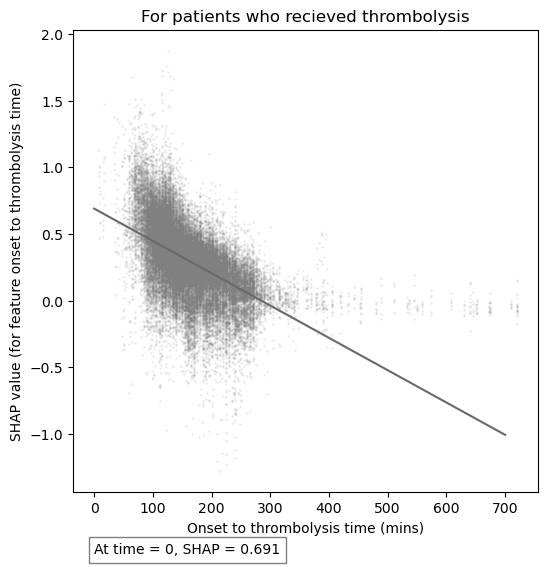

In [128]:
# Generate data
x = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"]
y = df_test_ivt_and_no_ivt_shap["ivt_shap_ivt"]

# Initialize layout
fig, ax = plt.subplots(figsize = (6, 6))

# Add scatterplot
ax.scatter(x, y, s=1, color='grey', alpha=0.1)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 700 
xseq = np.linspace(-0, 700, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="dimgray", lw=1.5);

ax.set_xlabel("Onset to thrombolysis time (mins)")
ax.set_ylabel("SHAP value (for feature onset to thrombolysis time)")
ax.set_title("For patients who recieved thrombolysis")

ax.text(0, -1.9, f"At time = 0, SHAP = {round(a,3)}", 
        bbox=dict(facecolor='white', alpha=0.5))

Here use seaborn

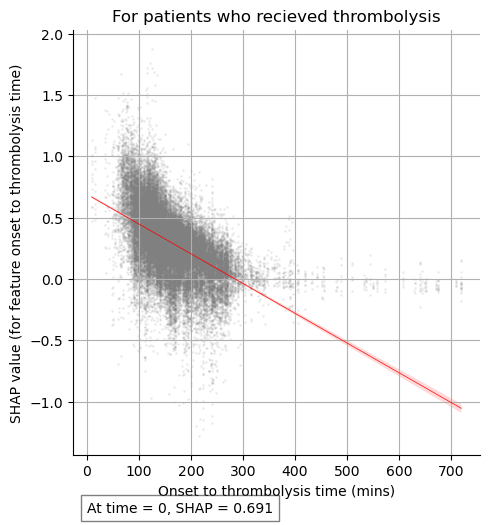

In [129]:
# Add seaborn regression plot with confidence intervals
fig = sns.lmplot(x="onset_to_thrombolysis_time", 
           y="ivt_shap_ivt", 
                data=df_test_ivt_and_no_ivt_shap, 
                markers='o', 
                x_jitter=0.1,
                scatter_kws={"alpha": 0.1, "s": 1, "color": 'grey'},
                line_kws={"lw": 0.5, "color": 'red'} 
                );

plt.xlabel("Onset to thrombolysis time (mins)")
plt.ylabel("SHAP value (for feature onset to thrombolysis time)")
plt.title("For patients who recieved thrombolysis")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x, y, deg=1)
plt.text(0, -1.9, f"At time = 0, SHAP = {round(a,3)}", 
        bbox=dict(facecolor='white', alpha=0.5))

plt.grid()
plt.show();


Zoom into the left most area of the red regression line to show that the confidence intervals are present, just very small, so not visible at the full zoom.

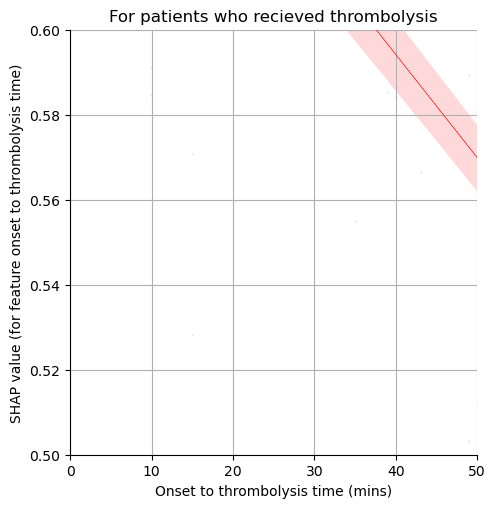

In [130]:
fig = sns.lmplot(x="onset_to_thrombolysis_time", 
           y="ivt_shap_ivt", 
                data=df_test_ivt_and_no_ivt_shap, 
                markers='o', 
                x_jitter=0.1,
                scatter_kws={"alpha": 0.1, "s": 1, "color": 'grey'},
                line_kws={"lw": 0.5, "color": 'red'} 
                );

plt.xlabel("Onset to thrombolysis time (mins)")
plt.ylabel("SHAP value (for feature onset to thrombolysis time)")
plt.title("For patients who recieved thrombolysis")

plt.ylim(0.5, 0.6)
plt.xlim(0, 50)

plt.grid()
plt.show();

In introduction, stated that "if the data represents the results of the Emberson meta analysis, at t=0 should see SHAP value 0.7. Should cross no effect line (SHAP value 0) at 6.3hours (378mins)."

Here are those numbers:

In [131]:
print(f"At t=0, SHAP value {round(a,3)} (log odds)")
print(f"No effect line (SHAP value 0) at {round(-a/b)} minutes")

At t=0, SHAP value 0.691 (log odds)
No effect line (SHAP value 0) at 285 minutes


For the patients that got treatment in the test set, plot the predicted probability of being a better outcome (for each of the threshold models) when had treatment, and without treatment (by overwriting the feature onset_to_thrombolysis_time with value 9999).

What time to use as cutoff for the colourmap in the figures that follow

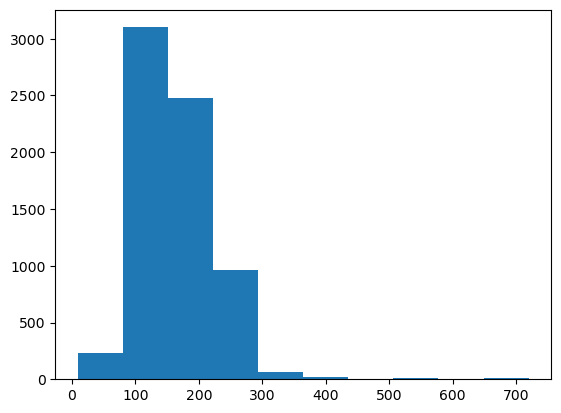

In [132]:
plt.hist(X_test["onset_to_thrombolysis_time"][mask_treated]);

### Plots for probability with and without treatment for each mRS threshold

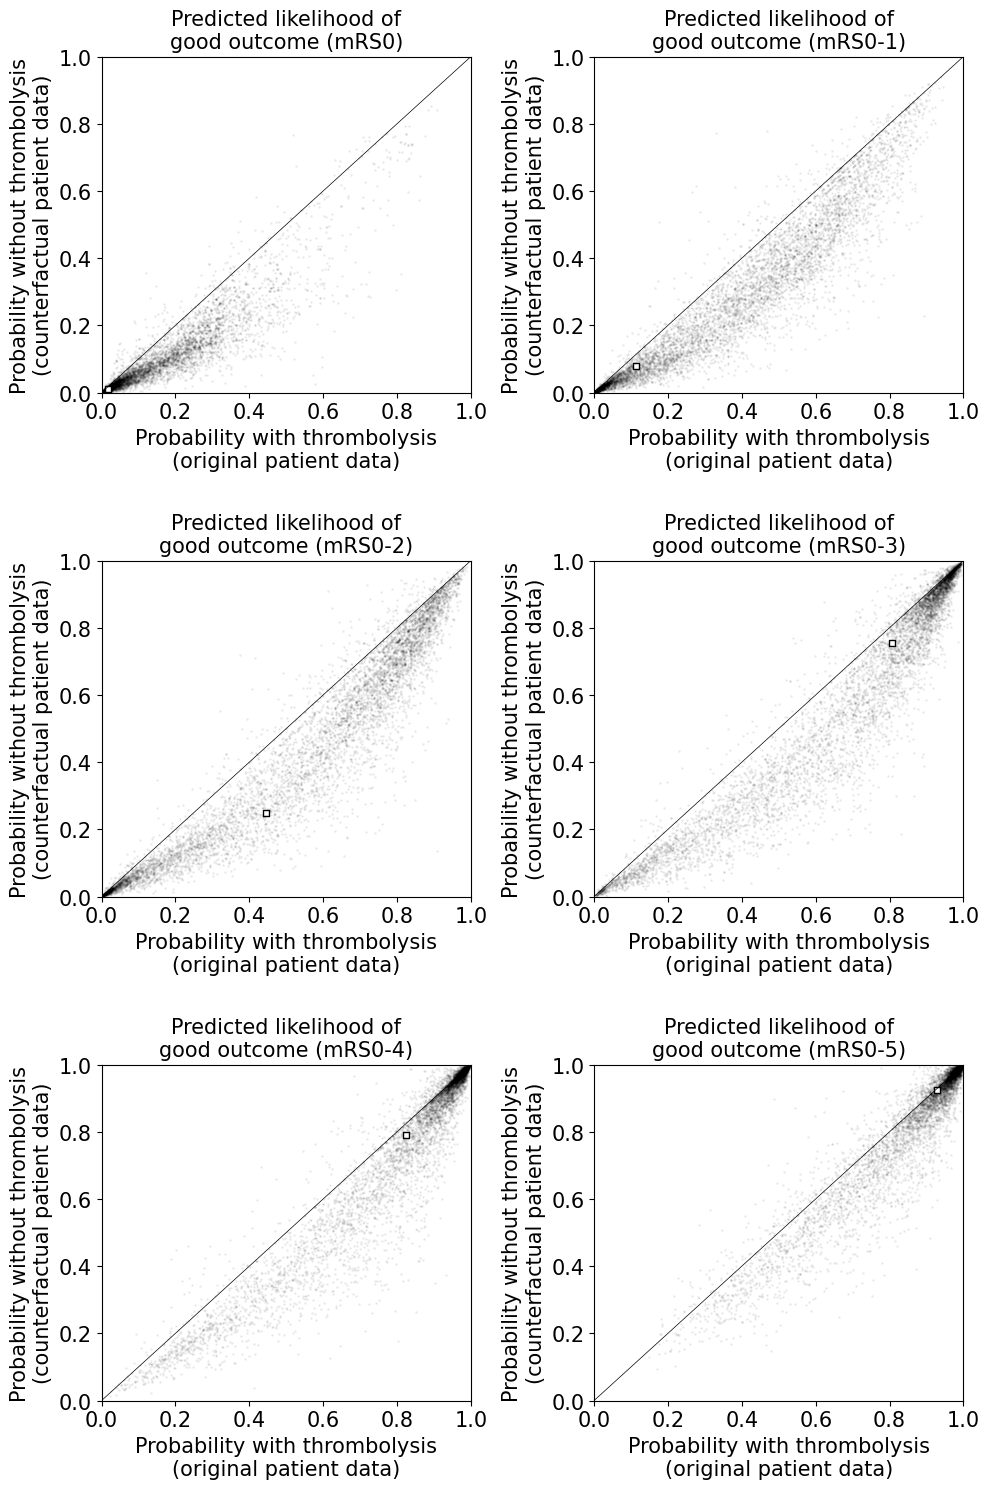

In [172]:
ncols=2
nrows=3
max_time = -9#400 #set to <0 to not have a mask for max time
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)

#fig.suptitle("Good outcome at discharge", fontsize=14)

# Set figure size
fig.set_size_inches(10,15)

# Mask treated and within time
mask_treated = X_test["onset_to_thrombolysis_time"] != surrogate_time_for_no_thrombolysis
if max_time > 0:
    mask_max_time = X_test["onset_to_thrombolysis_time"] <= max_time
    mask_treated_max_time = mask_treated * mask_max_time
else:
    mask_treated_max_time = mask_treated

individual = 7

row=0
col=0

for t in range(6):
    x = y_probs_threshold[t][mask_treated_max_time]
    y = y_probs_threshold_no_ivt[t][mask_treated_max_time]
    axs[row][col].scatter(x, y, c="k", alpha=0.05, s=1)
    axs[row][col].plot((0,1), (0,1), c="k", linewidth=0.5)
    axs[row][col].set_xlim((0,1))
    axs[row][col].set_ylim((0,1))
#    plt.scatter(y_probs_threshold[t][patient_ids_ivt_within_55mins[6]], y_probs_threshold_no_ivt[t][patient_ids_ivt_within_55mins[6]], c="white", s=15, marker="s")
#    plt.scatter(y_probs_threshold[t][patient_ids_ivt_within_55mins[6]], y_probs_threshold_no_ivt[t][patient_ids_ivt_within_55mins[6]], c="k", s=8, marker="s")
    axs[row][col].scatter(y_probs_threshold[t][mask_treated_max_time][individual], 
                          y_probs_threshold_no_ivt[t][mask_treated_max_time][individual], 
                          edgecolor="k", facecolor="white", s=15, marker="s", alpha=1)
#    axs[row][col].scatter(y_probs_threshold[t][mask_treated_max_time][individual], y_probs_threshold_no_ivt[t][mask_treated_max_time][individual], c="white", s=15, marker="s")
#    axs[row][col].scatter(y_probs_threshold[t][mask_treated_max_time][individual], y_probs_threshold_no_ivt[t][mask_treated_max_time][individual], c="k", s=8, marker="s")

    y_probs_threshold[t][mask_treated_max_time] - y_probs_threshold_no_ivt[t][mask_treated_max_time]

    if t == 0:
        title_str = f"{t}"
    else:
        title_str = f"0-{t}"

    axs[row][col].set_title(f"Predicted likelihood of\ngood outcome (mRS{title_str})", fontsize=15)
    axs[row][col].set_xlabel(f"Probability with thrombolysis\n(original patient data)", fontsize=15)
    axs[row][col].set_ylabel(f"Probability without thrombolysis\n(counterfactual patient data)", fontsize=15)
    axs[row][col].tick_params(axis='both', which='major', labelsize=15)
    col+=1
    if col==ncols:
        col=0
        row+=1
plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

filename_end = f"_max_time_mask_{max_time}"
if max_time < 0:
    filename_end = f"_no_max_time_mask"


filename = os.path.join(paths.image_save_path, (paths.notebook + 
                        paths.model_text + '_probability_shift_counterfactuals_kfold' + str(k) + 
                        f'{filename_end}.jpg'))

plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

Find patient that is above the equals line for all mRS thresholds.

In [134]:
mask0 = (y_probs_threshold_no_ivt[0][mask_treated]>y_probs_threshold[0][mask_treated])
mask1 = (y_probs_threshold_no_ivt[1][mask_treated]>y_probs_threshold[1][mask_treated])
mask2 = (y_probs_threshold_no_ivt[2][mask_treated]>y_probs_threshold[2][mask_treated])
mask3 = (y_probs_threshold_no_ivt[3][mask_treated]>y_probs_threshold[3][mask_treated])
mask4 = (y_probs_threshold_no_ivt[4][mask_treated]>y_probs_threshold[4][mask_treated])
mask5 = (y_probs_threshold_no_ivt[5][mask_treated]>y_probs_threshold[5][mask_treated])

In [135]:
set0 = set(np.where(mask0==True)[0])
set1 = set(np.where(mask1==True)[0])
set2 = set(np.where(mask2==True)[0])
set3 = set(np.where(mask3==True)[0])
set4 = set(np.where(mask4==True)[0])
set5 = set(np.where(mask5==True)[0])

lst = [set0, set1, set2, set3, set4, set5]
set.intersection(*lst)

{785, 2912, 3145, 4411, 5079, 5309, 5339}

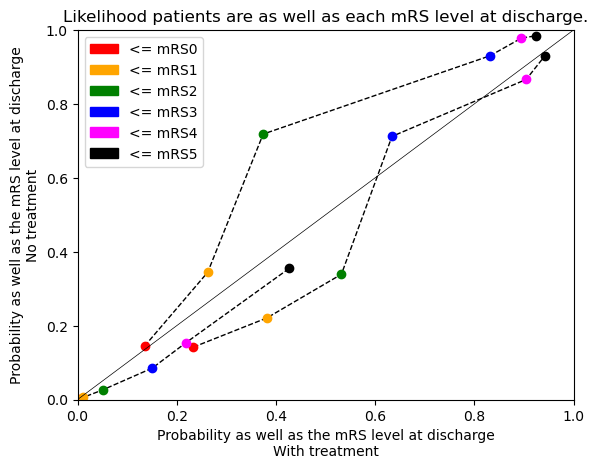

In [136]:
legend_patch0 = mpatches.Patch(color='red', label='<= mRS0')
legend_patch1 = mpatches.Patch(color='orange', label='<= mRS1')
legend_patch2 = mpatches.Patch(color='green', label='<= mRS2')
legend_patch3 = mpatches.Patch(color='blue', label='<= mRS3')
legend_patch4 = mpatches.Patch(color='magenta', label='<= mRS4')
legend_patch5 = mpatches.Patch(color='k', label='<= mRS5')

mask_treated = X_test["onset_to_thrombolysis_time"]<surrogate_time_for_no_thrombolysis
mask_not_treated = X_test["onset_to_thrombolysis_time"]==surrogate_time_for_no_thrombolysis
color=["red", "orange","green","blue","magenta","k"]

ls = ["--","--","--"]

for c, p in enumerate([1, 44, 4411]):#,158,198, 32,4, 32, 25]:#40,32,25,7]:#len(patient_ids_ivt_within_55mins)):
    x, y = [], []
    for t in range(6):
#        x.append(y_probs_threshold[t][patient_ids_ivt_within_55mins[p]])
#        y.append(y_probs_threshold_no_ivt[t][patient_ids_ivt_within_55mins[p]])
        x.append(y_probs_threshold[t][mask_treated][p])
        y.append(y_probs_threshold_no_ivt[t][mask_treated][p])
    plt.plot(x, y, linewidth=1, c="k", linestyle=ls[c])
    for t in range(6):
        plt.plot(y_probs_threshold[t][mask_treated][p], y_probs_threshold_no_ivt[t][mask_treated][p], marker="o", c=color[t])
plt.legend(handles=[legend_patch0,legend_patch1,legend_patch2,legend_patch3,legend_patch4,legend_patch5])
#    plt.legend()
#    plt.plot(x, y, linewidth=0.5, marker="o", c=color)

plt.xlim((0,1))
plt.ylim((0,1))

plt.title(f"Likelihood patients are as well as each mRS level at discharge.")
plt.xlabel(f"Probability as well as the mRS level at discharge\nWith treatment")
plt.ylabel(f"Probability as well as the mRS level at discharge\nNo treatment")

plt.plot((0,1), (0,1), c="k", linewidth=0.5)

plt.show()

## Plot the linear regression of improved SHAP due to treatment

Define a function to plot using matplotlib (using subplot_mosaic to get the layout) the estimated improvement in discharge disability that's associated with thrombolysis treatment (to fit the linear regressions, limit the data to patients who received thrombolysis within 300 minutes of stroke onset)

In [137]:
def create_mosaic_plot(df_test_ivt_and_no_ivt_shap, max_treatment_time, 
                       filename_suffix, title_suffix):
    """ 
    
    
    """
    fig, ax = plt.subplot_mosaic(
        [
        ['main', 'mRS0', 'mRS1', 'mRS2'],
        ['main', 'mRS3', 'mRS4', 'mRS5'],
        ],
        width_ratios=[2, 1, 1, 1],
        layout='constrained',
        figsize=(15,6),
    )
    plt.rcParams['legend.title_fontsize'] = 'x-small'

    fig.suptitle(f"Estimated improvement in discharge disability that's "
                 f"associated with thrombolysis treatment\n(to fit the linear "
                 f"regressions, limit the data to patients who received "
                 f"thrombolysis within {max_treatment_time} minutes of stroke "
                 f"onset)\n{title_suffix}")

    handles = []

    point_color = ["red", "orange", "yellow", "green", "blue", "mediumorchid"]
    line_color = ["firebrick", "darkorange", "gold", "darkgreen", "mediumblue", 
                  "darkorchid"]
#    text = "With 0 minutes onset to thrombolysis time:"
    label = ["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"]

    max_zero_effect = 0
    for t in range(6):

        mask = df_test_ivt_and_no_ivt_shap["mRS_threshold"] == t

        # Generate data
        x = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask]
        y = df_test_ivt_and_no_ivt_shap["ivt_shap_ivt_improvement"][mask]

        # Add scatterplot
        ax['main'].scatter(x, y, s=1, color = 'grey', alpha=0.1)
        ax[f'mRS{t}'].scatter(x, y, s=1, alpha=0.3, color=point_color[t],
                              label=label[t])
    
        # Fit linear regression via least squares with numpy.polyfit
        # It returns an slope (b) and intercept (a)
        # deg=1 means linear fit (i.e. polynomial of degree 1)
        b, a = np.polyfit(x, y, deg=1)
        # Want to set xlim max to include all of the zero effects (where SHAP = 0)
        zero_effect = -a/b
        max_zero_effect = max(max_zero_effect, zero_effect)

    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    x = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"]
    y = df_test_ivt_and_no_ivt_shap["ivt_shap_ivt_improvement"]
    b, a = np.polyfit(x, y, deg=1)

    # Want to set xlim max to include all of the zero effects (where SHAP = 0)
    zero_effect = -a/b
    max_zero_effect = max(max_zero_effect, zero_effect)

    # Create sequence of 100 numbers from 0 to max zero limit
    xseq = np.linspace(0, max_zero_effect, num=100)

    # Plot regression line
    l, = ax['main'].plot(xseq, a + b * xseq, color="dimgray", lw=2.5, 
                         label="All mRS thresholds");

    ax['main'].set_title(f"All mRS levels\n(No effect at {round(-a/b)} minutes)"
                         f"\n({round(a,3)} log odds at 0 minutes)", fontsize=7)

    # Now have max_zero_limit can plot the linear regression fit
    for t in range(6):
        mask = df_test_ivt_and_no_ivt_shap["mRS_threshold"] == t
        # Generate data
        x = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask]
        y = df_test_ivt_and_no_ivt_shap["ivt_shap_ivt_improvement"][mask]
        # Fit linear regression via least squares with numpy.polyfit
        # It returns an slope (b) and intercept (a)
        # deg=1 means linear fit (i.e. polynomial of degree 1)
        b, a = np.polyfit(x, y, deg=1)

        ax[f'mRS{t}'].plot(xseq, a + b * xseq, color=line_color[t], lw=1.5)
        ax[f'mRS{t}'].set_title(f"mRS at or below {t}\n(No effect at "
                                f"{round(-a/b)} minutes\n{round(a,3)} log odds"
                                f" at 0 minutes)", fontsize=7)
        ax[f'mRS{t}'].set_xlabel("Onset to thrombolysis time (minutes)", 
                                 fontsize=7)
        ax[f'mRS{t}'].set_ylabel(f"Improvement (log odds)", fontsize=7)
        ax[f'mRS{t}'].set_xlim(0, max_zero_effect)
        ax[f'mRS{t}'].plot([0,max_zero_effect] ,[0,0], c='0.3', linewidth=1)

#        text = text + f"\n    mRS at or below {t} = {round(a,3)} log odds"


#    ax['main'].text(10, -1.8, text, fontsize=7, bbox=dict(facecolor='white', alpha=0.5))
    ax['main'].plot([0,max_zero_effect],[0,0],c='0.3',linewidth=1)

    #ax.legend(['First line', 'Second line'])
    #ax['main'].legend(handles=handles,framealpha=1)
#    ax['main'].legend(title="mRS threshold",fontsize='small', loc='upper left', prop = { "size": 7})#(label)#,framealpha=1)
    #handles.append(l)
    ax['main'].set_xlabel("Onset to thrombolysis time (minutes)")
    ax['main'].set_ylabel("Estimated improvement associated with treatment"
                          "\n(log odds improvements in being below mRS "
                          "threshold)")
    ylim_main = ax['main'].get_ylim()
    yticks_main = ax['main'].get_yticks()

    ax['main'].set_xlim(0,max_zero_effect)#max_treatment_time)
    for t in range(6):
        ax[f'mRS{t}'].set_xlim(0,max_zero_effect)

    #l.legend_elements(prop='colors', num=20)

    #leg = ax['main'].get_legend()
    #for t in range(6):
    #    leg.legendHandles[t].set_color(line_color[t])

    #x_pos = ax['main'].get_xticklabels()
    for t in range(6):
        ax[f'mRS{t}'].set_yticks(yticks_main)
        ax[f'mRS{t}'].set_yticklabels(yticks_main,fontsize=7)
        ax[f'mRS{t}'].set_ylim(ylim_main)
    #    ax[f'mRS{t}'].set_xticklabels(fontsize=7)
        ax[f'mRS{t}'].tick_params(axis='x', labelsize=7)

    filename = os.path.join(paths.image_save_path, (paths.notebook + paths.model_text + 
                '_improvement_logodds_bymRSthreshold_plt_subplots' + filename_suffix + '.jpg'))

    plt.savefig(filename, dpi=300)

    fig.canvas.draw()

    return()

Define a function using seaborn to plot (using subplot_mosaic to get the layout) the estimated improvement in discharge disability that's associated with thrombolysis treatment (to fit the linear regressions, limit the data to patients who received thrombolysis within 300 minutes of stroke onset)

In [138]:
def create_sns_mosaic_plot(df, max_treatment_time, 
                       filename_suffix, title_suffix, monochrome=False):
    
    mask_max_time = (df["onset_to_thrombolysis_time"] <= max_treatment_time)

    # Define colour for the threshold plots
    if monochrome:
        point_color = ["k", "k", "k", "k", "k", "k"]
    else:
        point_color = ["red", "darkorange", "gold", "green", "blue", "mediumorchid"]
#    line_color = ["firebrick", "darkorange", "gold", "darkgreen", "mediumblue", 
#                    "darkorchid"]

    # Define x and y axis labels to use in all subplots
    xlabel = "Onset to thrombolysis time (minutes)"
    ylabel_main = ("Estimated improvement associated with treatment"
                "\n(log odds improvements in being below mRS threshold)")
    ylabel = ("Improvement (log odds)")

    # Define the mosaic layout
    fig, ax = plt.subplot_mosaic(
        [
        ['main', 'mRS0', 'mRS1', 'mRS2'],
        ['main', 'mRS3', 'mRS4', 'mRS5'],
        ],
        width_ratios=[2, 1, 1, 1],
        layout='constrained',
        figsize=(15,6),
    )

    # Set overall figure title
    fig.suptitle(f"Estimated improvement in discharge disability that's "
                    f"associated with thrombolysis treatment\n(to fit the linear "
                    f"regressions, limit the data to patients who received "
                    f"thrombolysis within {max_treatment_time} minutes of stroke "
                    f"onset)\n{title_suffix}")


    # For each threshold level plot the subplots
    for t in range(6):

        # Get the data for this plot
        mask = df["mRS_threshold"] == t
        mask = mask * mask_max_time
        # Add seaborn regression plot with confidence intervals
        sns.regplot(x="onset_to_thrombolysis_time", y="ivt_shap_ivt_improvement", 
                        data=df[mask], 
                        x_jitter=0.1,
                        scatter_kws={"alpha": 0.1, "s": 1, "color": point_color[t]},
                        line_kws={"lw": 0.5, "color": point_color[t]}, 
                        ax=ax[f'mRS{t}']);

        ax[f'mRS{t}'].set_xlabel(xlabel)
        ax[f'mRS{t}'].set_ylabel(ylabel)
    #    ax[f'mRS{t}'].set_xlim(290,300)

        # Fit linear regression via least squares with numpy.polyfit
        # It returns an slope (b) and intercept (a)
        # deg=1 means linear fit (i.e. polynomial of degree 1)
        x = df["onset_to_thrombolysis_time"][mask]
        y = df["ivt_shap_ivt_improvement"][mask]
        b, a = np.polyfit(x, y, deg=1)
        
        ax[f'mRS{t}'].set_title(f"mRS at or below {t}\n"
                                f"(No effect at "
                                f"{round(-a/b)} minutes\n{round(a,3)} log odds"
                                f" at 0 minutes)", fontsize=7)

    sns.regplot(x="onset_to_thrombolysis_time", y="ivt_shap_ivt_improvement", 
                data=df[mask_max_time], 
                x_jitter=0.1,
                scatter_kws={"alpha": 0.1, "s": 1, "color": 'k'},
                line_kws={"lw": 0.5, "color": 'k'}, 
                ax=ax['main']);
    ax['main'].set_xlabel(xlabel)
    ax['main'].set_ylabel(ylabel_main)
    #ax['main'].set_xlim(290,300)

    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    x = df["onset_to_thrombolysis_time"][mask_max_time]
    y = df["ivt_shap_ivt_improvement"][mask_max_time]
    b, a = np.polyfit(x, y, deg=1)

    ax['main'].set_title(f"All mRS levels\n(No effect at {round(-a/b)} minutes)"
                            f"\n({round(a,3)} log odds at 0 minutes)", fontsize=7)

    ylim_main = ax['main'].get_ylim()
    yticks_main = ax['main'].get_yticks()

#    ax['main'].set_xlim(0,max_zero_effect)#max_treatment_time)
#    for t in range(6):
#        ax[f'mRS{t}'].set_xlim(0,max_zero_effect)

    for t in range(6):
        ax[f'mRS{t}'].set_yticks(yticks_main)
        ax[f'mRS{t}'].set_yticklabels(yticks_main,fontsize=7)
        ax[f'mRS{t}'].set_ylim(ylim_main)
        ax[f'mRS{t}'].tick_params(axis='x', labelsize=7)

    filename = os.path.join(paths.image_save_path, (paths.notebook + paths.model_text + 
                '_improvement_logodds_bymRSthreshold_sns_subplots' + filename_suffix + '.jpg'))

    plt.savefig(filename, dpi=300)

    fig.canvas.draw()

    plt.show()
    
    return()

Define the max duration to limit the data to patients who received thrombolysis within that many minutes of stroke onset (to fit the linear regressions)

In [139]:
max_treatment_time = 300

nonlvo_threshold = 10

mask_max_time = (df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"] <= 
                                                        max_treatment_time)

mask_nlvo = df_test_ivt_and_no_ivt_shap["stroke_severity"] <= nonlvo_threshold
mask_nlvo_time = mask_nlvo * mask_max_time

mask_lvo = df_test_ivt_and_no_ivt_shap["stroke_severity"] > nonlvo_threshold
mask_lvo_time = mask_lvo * mask_max_time

Fit linear regression to patients treated within a max time for these subgroups:
* LVO and nonLVO
* LVO only
* nLVO only

Create each figure twice, using: 
* Matplotlib
* Seaborn

LVO and nonLVO using Matplotlib

()

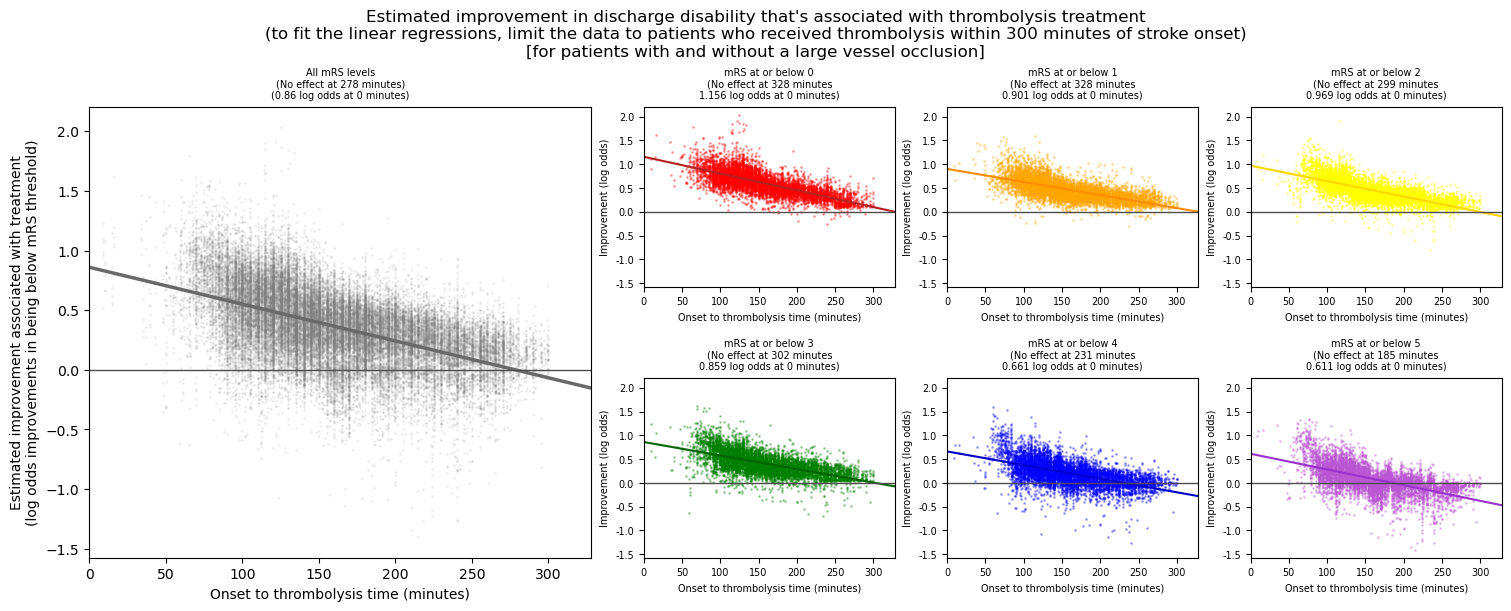

In [140]:
create_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask_max_time], 
                   max_treatment_time, "_nLVO_LVO", 
                   "[for patients with and without a large vessel occlusion]")

LVO and nonLVO using Seaborn

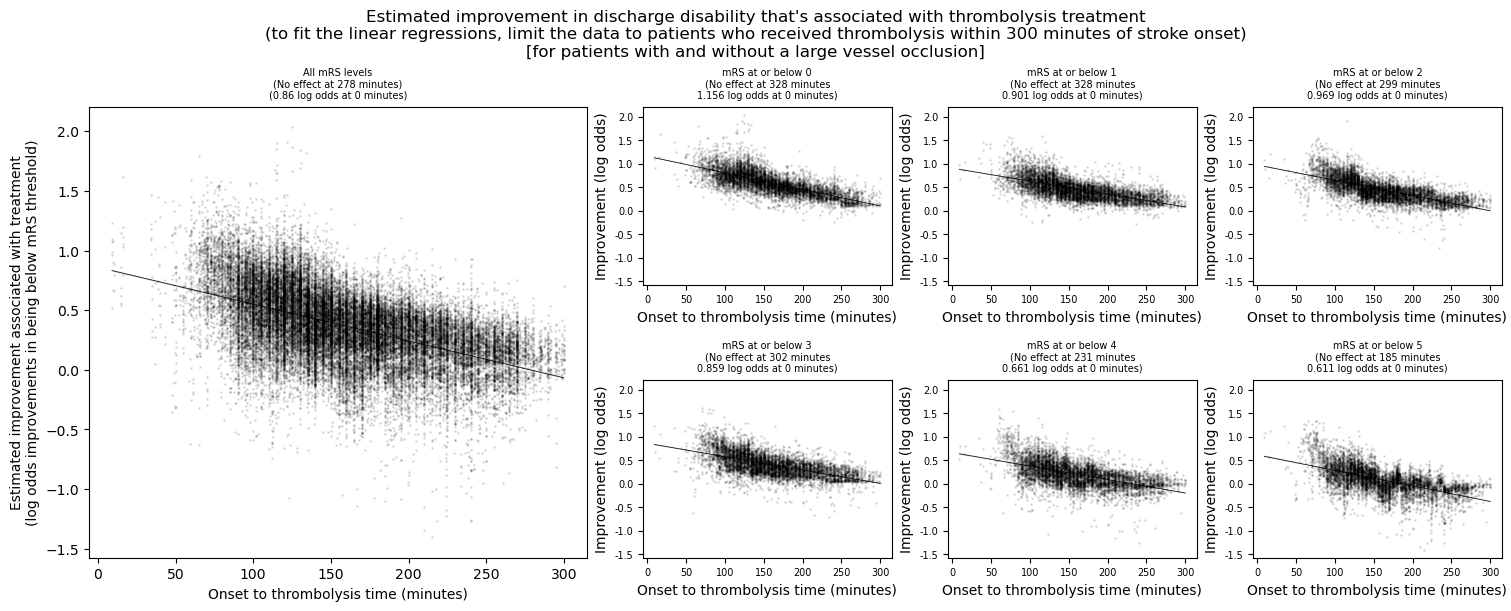

()

In [141]:
create_sns_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask_max_time], 
                   max_treatment_time, "_nLVO_LVO", 
                   "[for patients with and without a large vessel occlusion]",
                   monochrome=True)

Repeat the plot for two subpopulations: LVO vs non-LVO
Use cutoff of NIHSS <= 10 as surrogate to identify an nLVO
Use cutoff of NIHSS >= 11 as surrogate to identify an LVO

LVO only using matplotlib

()

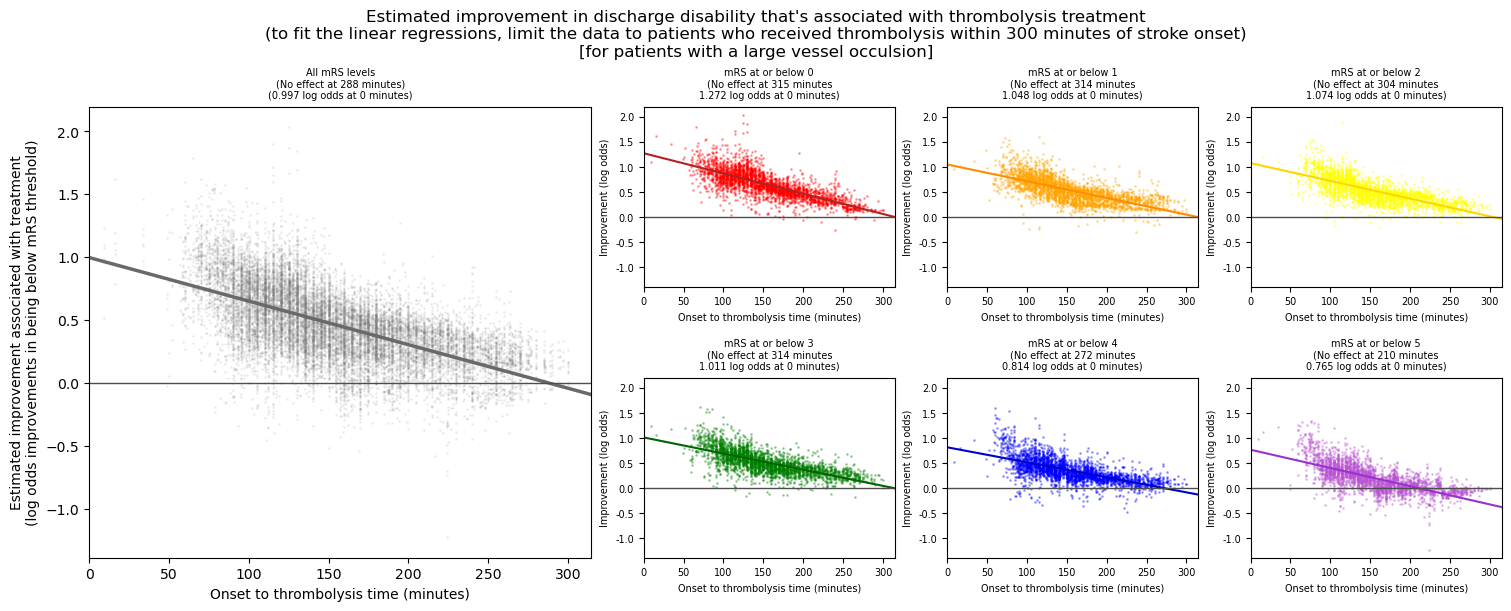

In [142]:
create_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask_lvo_time], max_treatment_time, 
                   "_LVO", "[for patients with a large vessel occulsion]")

LVO only using seaborn

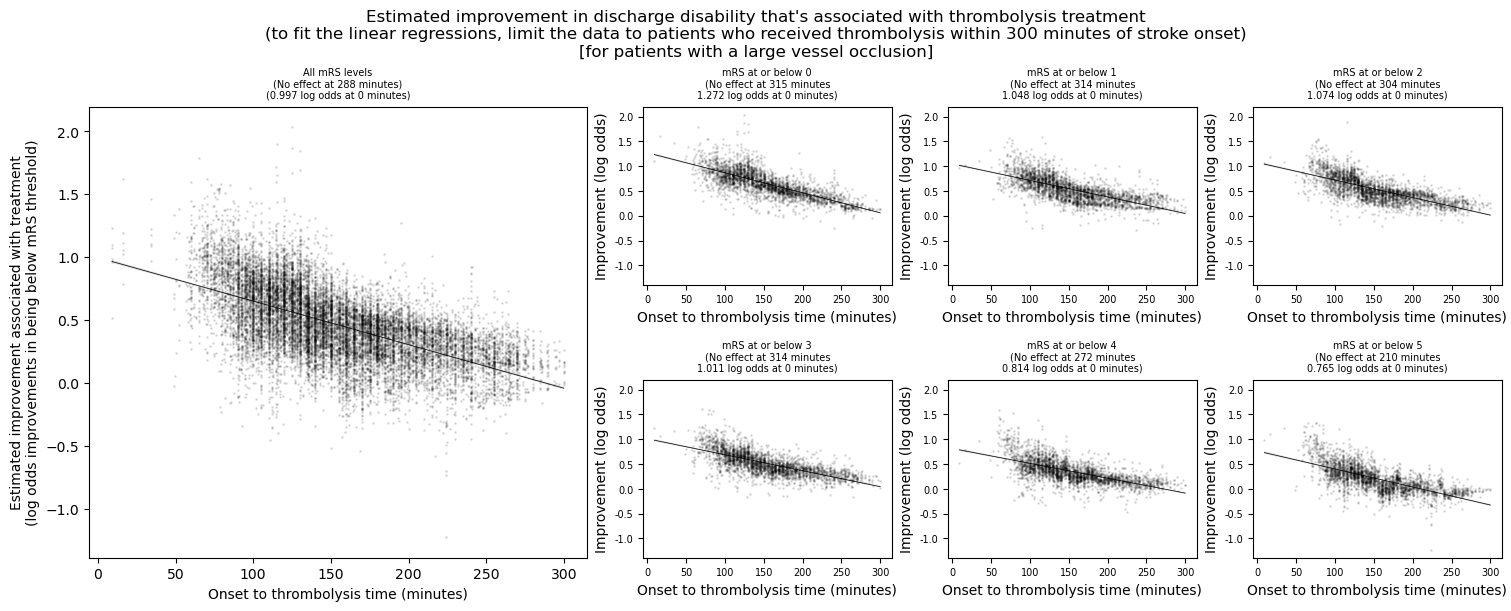

()

In [143]:
create_sns_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask_lvo_time], 
                   max_treatment_time, "_LVO", 
                   "[for patients with a large vessel occlusion]",
                   monochrome=True)

nLVO only using matplotlib

()

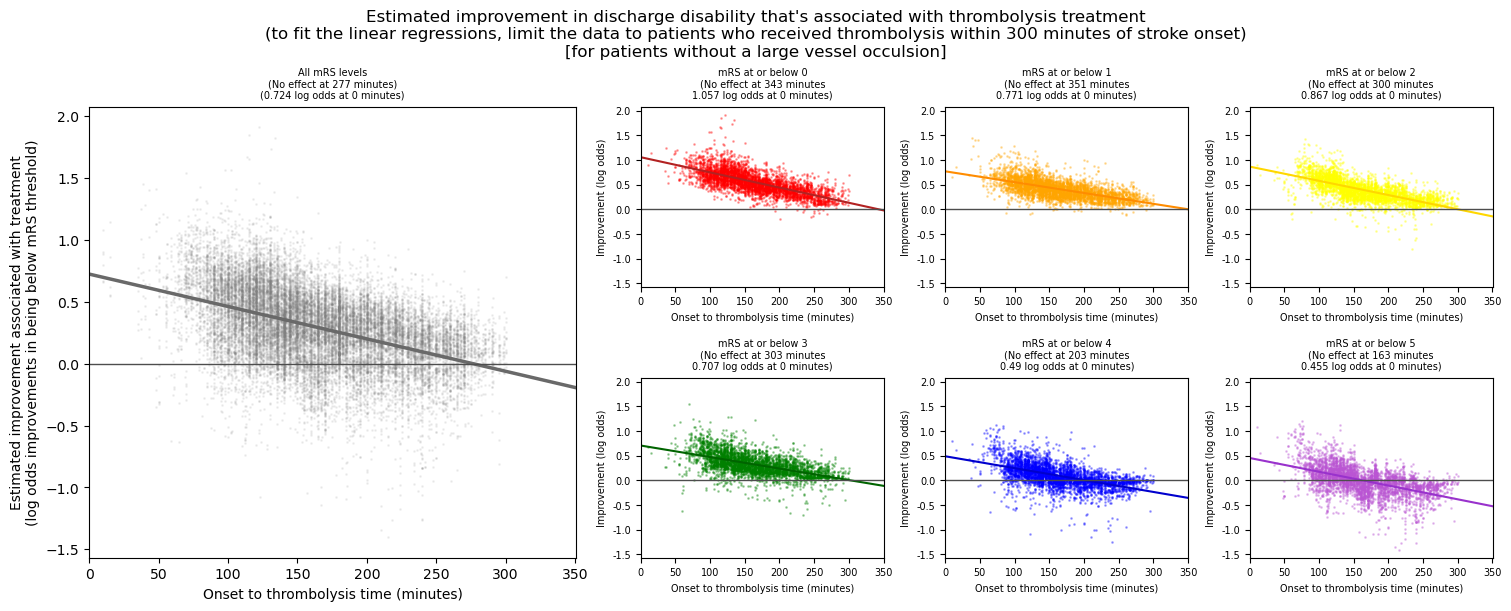

In [144]:
create_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask_nlvo_time], max_treatment_time, 
                   "_nLVO", "[for patients without a large vessel occulsion]")

nLVO only using Seaborn

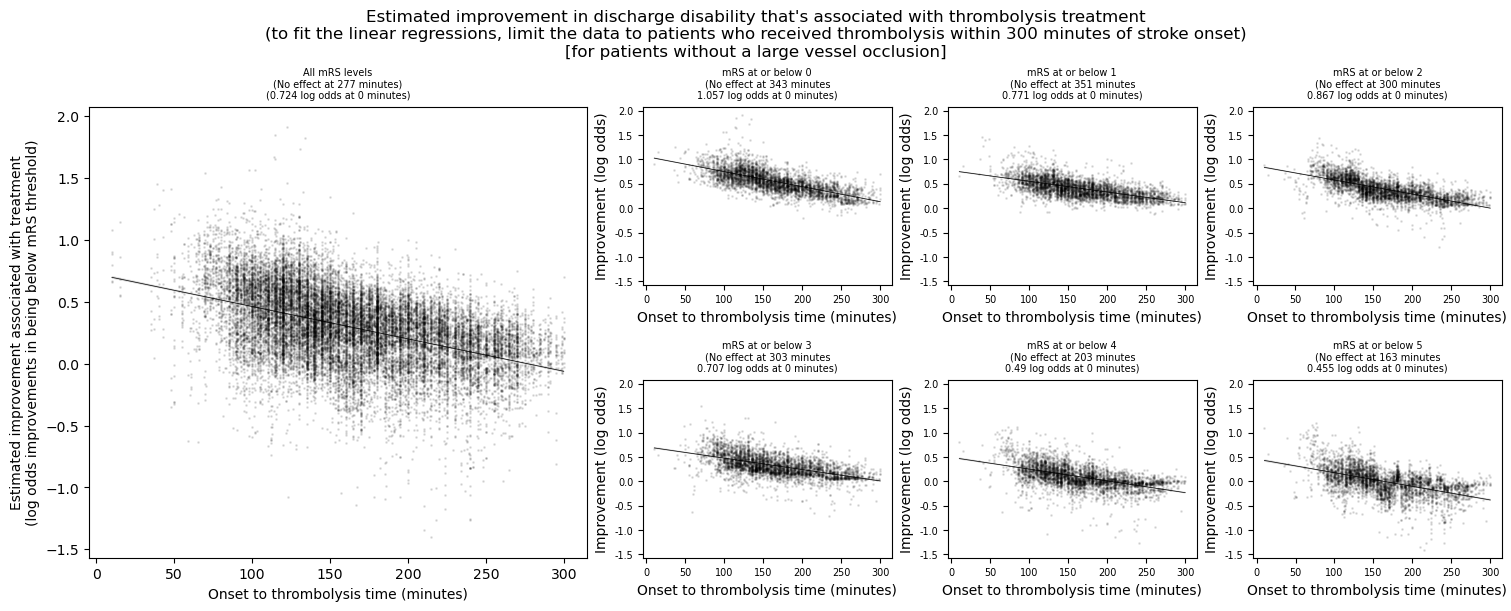

()

In [145]:
create_sns_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask_nlvo_time], 
                   max_treatment_time, "_nLVO", 
                   "[for patients without a large vessel occlusion]",
                   monochrome=True) 

In [181]:
def create_sns_mosaic_plot_for_paper(df, max_treatment_time, 
                       filename_suffix, title_suffix, monochrome=False,
                       total_shap_values=False):

    if total_shap_values:
        shap_col_name = "total_shap_ivt_improvement"
        filename_suffix = filename_suffix + "_total_shap"
    else:
        shap_col_name = "ivt_shap_ivt_improvement"
        filename_suffix = filename_suffix + "_ivt_shap"

    if max_treatment_time > 0:    
        mask_max_time = (df["onset_to_thrombolysis_time"] <= max_treatment_time)
    else:
        mask_max_time = (df["onset_to_thrombolysis_time"] > -999)

    # Define colour for the threshold plots
    if monochrome:
        point_color = ["k", "k", "k", "k", "k", "k"]
    else:
        point_color = ["red", "darkorange", "gold", "green", "blue", "mediumorchid"]
#    line_color = ["firebrick", "darkorange", "gold", "darkgreen", "mediumblue", 
#                    "darkorchid"]

    # Define x and y axis labels to use in all subplots
    xlabel = "Onset to thrombolysis time (minutes)"
    ylabel_main = ("Predicted shift in log odds of having a good\noutcome at "
                   "discharge, associated with treatment")
    ylabel = ("Predicted shift in log odds")

    # Define the mosaic layout
    fig, ax = plt.subplot_mosaic(
        [
        ['main', 'mRS0', 'mRS1', 'mRS2'],
        ['main', 'mRS3', 'mRS4', 'mRS5'],
        ],
        width_ratios=[2, 1, 1, 1],
        layout='constrained',
        figsize=(15,6),
    )

    # Set overall figure title
#    fig.suptitle(f"Estimated improvement in discharge disability that's "
#                    f"associated with thrombolysis treatment\n(to fit the linear "
#                    f"regressions, limit the data to patients who received "
#                    f"thrombolysis within {max_treatment_time} minutes of stroke "
#                    f"onset)\n{title_suffix}")


    # For each threshold level plot the subplots
    linear_reg_fit_str = []
    for t in range(6):

        # Get the data for this plot
        mask = df["mRS_threshold"] == t
        mask = mask * mask_max_time
        # Add seaborn regression plot with confidence intervals
        sns.regplot(x="onset_to_thrombolysis_time", y=shap_col_name, 
                        data=df[mask], 
                        x_jitter=0.1,
                        scatter_kws={"alpha": 0.1, "s": 1, "color": point_color[t]},
                        line_kws={"lw": 0.5, "color": point_color[t]}, 
                        ax=ax[f'mRS{t}']);

        ax[f'mRS{t}'].set_xlabel(xlabel, fontsize=10)
        ax[f'mRS{t}'].set_ylabel(ylabel, fontsize=10)
    #    ax[f'mRS{t}'].set_xlim(290,300)

        # Fit linear regression via least squares with numpy.polyfit
        # It returns an slope (b) and intercept (a)
        # deg=1 means linear fit (i.e. polynomial of degree 1)
        x = df["onset_to_thrombolysis_time"][mask]
        y = df[shap_col_name][mask]
        b, a = np.polyfit(x, y, deg=1)
        
        if t == 0:
            title_str = f"mRS{t}"
        else:
            title_str = f"mRS0-{t}"

        ax[f'mRS{t}'].set_title(f"Good outcome: {title_str}", fontsize=12)

        linear_reg_fit_str.append((
                f"No effect: {round(-a/b)} mins\n"
                 f"At 0 minutes: {round(a,3)} log odds"))


    sns.regplot(x="onset_to_thrombolysis_time", y=shap_col_name, 
                data=df[mask_max_time], 
                x_jitter=0.1,
                scatter_kws={"alpha": 0.1, "s": 1, "color": 'k'},
                line_kws={"lw": 0.5, "color": 'k'}, 
                ax=ax['main']);
    #ax['main'].set_xlim(290,300)

    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    x = df["onset_to_thrombolysis_time"][mask_max_time]
    y = df[shap_col_name][mask_max_time]
    b, a = np.polyfit(x, y, deg=1)

    main_text = (f"No effect: {round(-a/b)} mins\n"
                 f"At 0 minutes: {round(a,3)} log odds")

    ax['main'].set_title(f"Good outcome: all mRS thresholds (common odds ratio)", 
                         fontsize=12)
    #f"All mRS levels\n(No effect at {round(-a/b)} minutes)"
    #f"\n({round(a,3)} log odds at 0 minutes)"

    ylim_main = ax['main'].get_ylim()
    yticks_main = ax['main'].get_yticks()

    ax['main'].set_ylim(ylim_main)
    ax['main'].set_xlabel(xlabel, fontsize=13)
    ax['main'].set_ylabel(ylabel_main, fontsize=13)
    ax['main'].set_yticks(yticks_main)
    ax['main'].set_yticklabels(yticks_main, fontsize=13)
    ax['main'].tick_params(axis='x', labelsize=13)
    ax[f'main'].text(0,ylim_main[0]*1,main_text, fontsize=11)

#    ax['main'].set_xlim(0,max_zero_effect)#max_treatment_time)
#    for t in range(6):
#        ax[f'mRS{t}'].set_xlim(0,max_zero_effect)

    for t in range(6):
        ax[f'mRS{t}'].set_yticks(yticks_main)#, fontsize=15)
        ax[f'mRS{t}'].set_yticklabels(yticks_main,fontsize=12)
        ax[f'mRS{t}'].set_ylim(ylim_main)
        ax[f'mRS{t}'].tick_params(axis='x', labelsize=12)
        ax[f'mRS{t}'].text(0,ylim_main[0]*0.95,linear_reg_fit_str[t], fontsize=10)

#    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=1)
    filename = os.path.join(paths.image_save_path, (paths.notebook + paths.model_text + 
                '_improvement_logodds_bymRSthreshold_sns_subplots' + filename_suffix + '_paper.jpg'))


    plt.savefig(filename, dpi=300)

    fig.canvas.draw()

    plt.show()
    
    return()

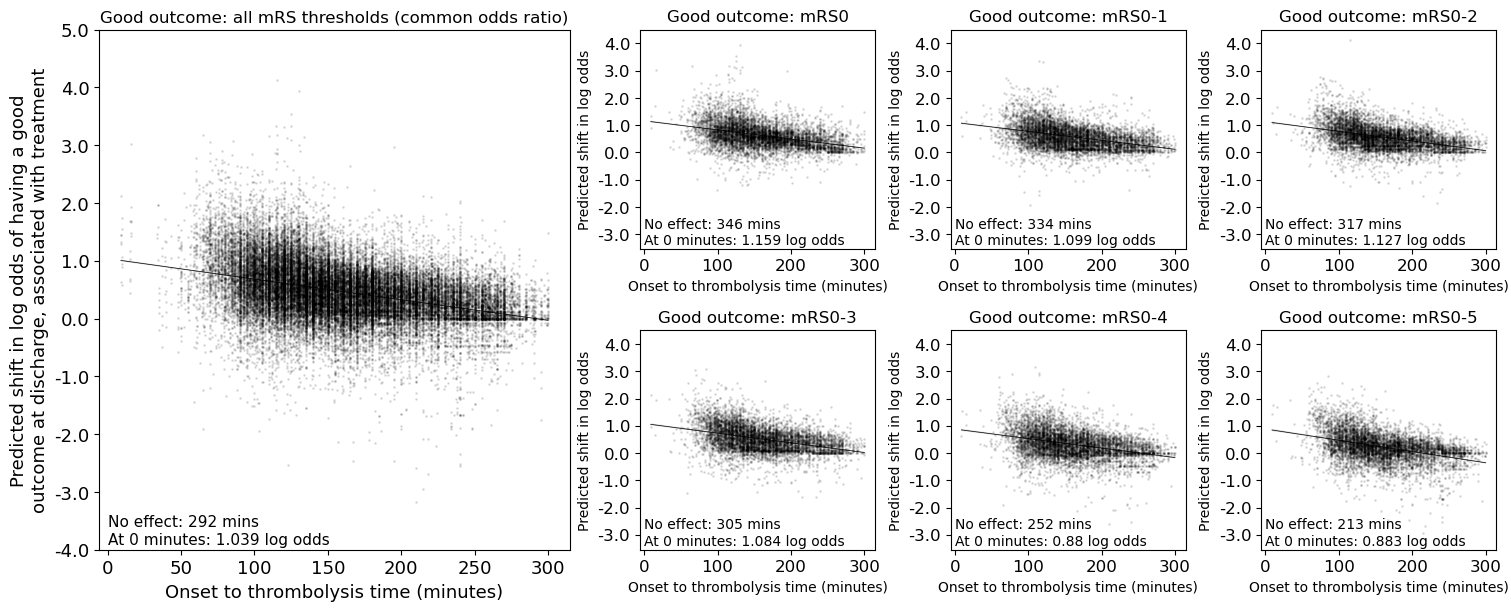

()

In [177]:
create_sns_mosaic_plot_for_paper(df_test_ivt_and_no_ivt_shap, 
                   300, "_nLVO_LVO", 
                   "[for patients with and without a large vessel occlusion]",
                   monochrome=True, total_shap_values=True)

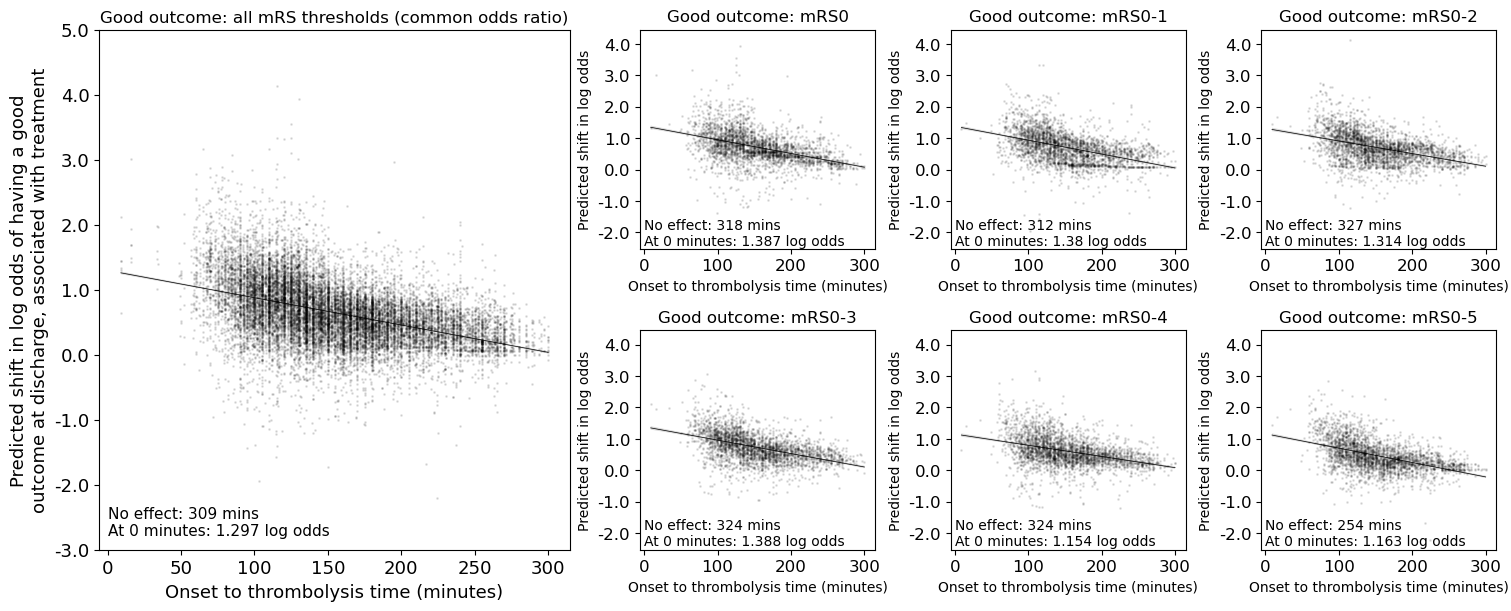

()

In [178]:
create_sns_mosaic_plot_for_paper(df_test_ivt_and_no_ivt_shap[mask_lvo], 
                   300, "_LVO", 
                   "[for patients with a large vessel occlusion]",
                   monochrome=True, total_shap_values=True)

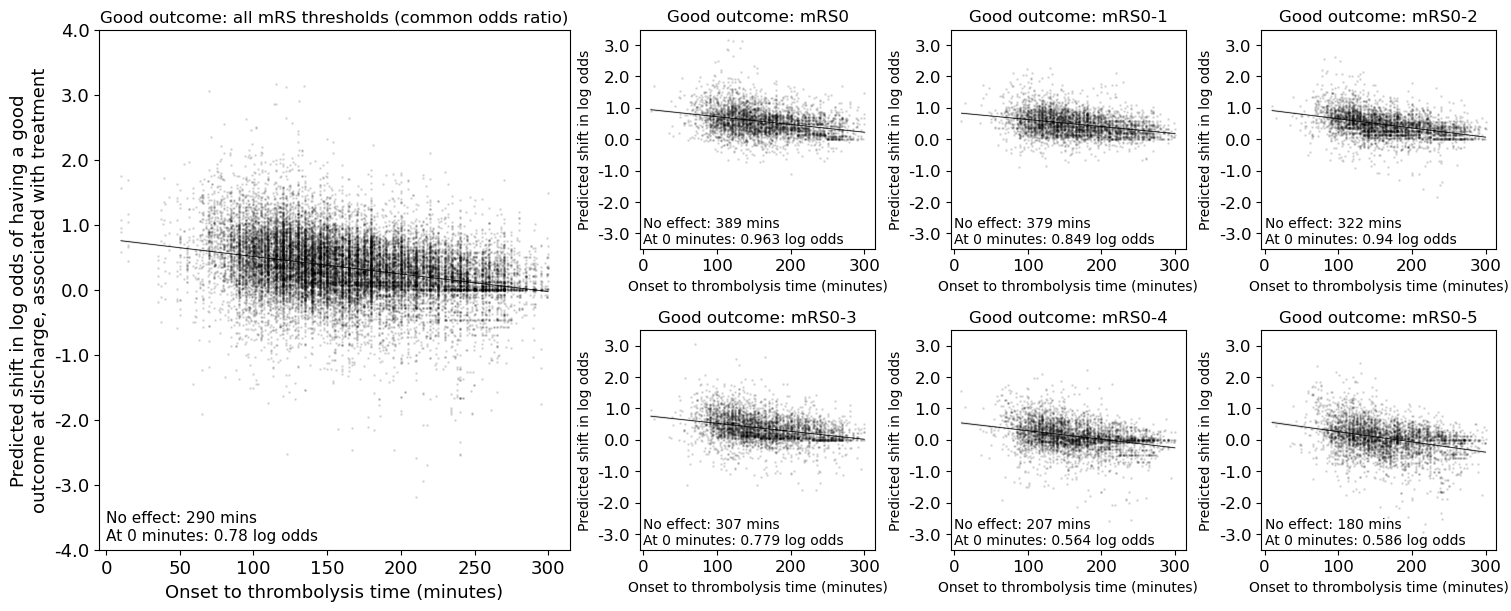

()

In [179]:
create_sns_mosaic_plot_for_paper(df_test_ivt_and_no_ivt_shap[mask_nlvo], 
                   300, "_nLVO", 
                   "[for patients with a large vessel occlusion]",
                   monochrome=True, total_shap_values=True)

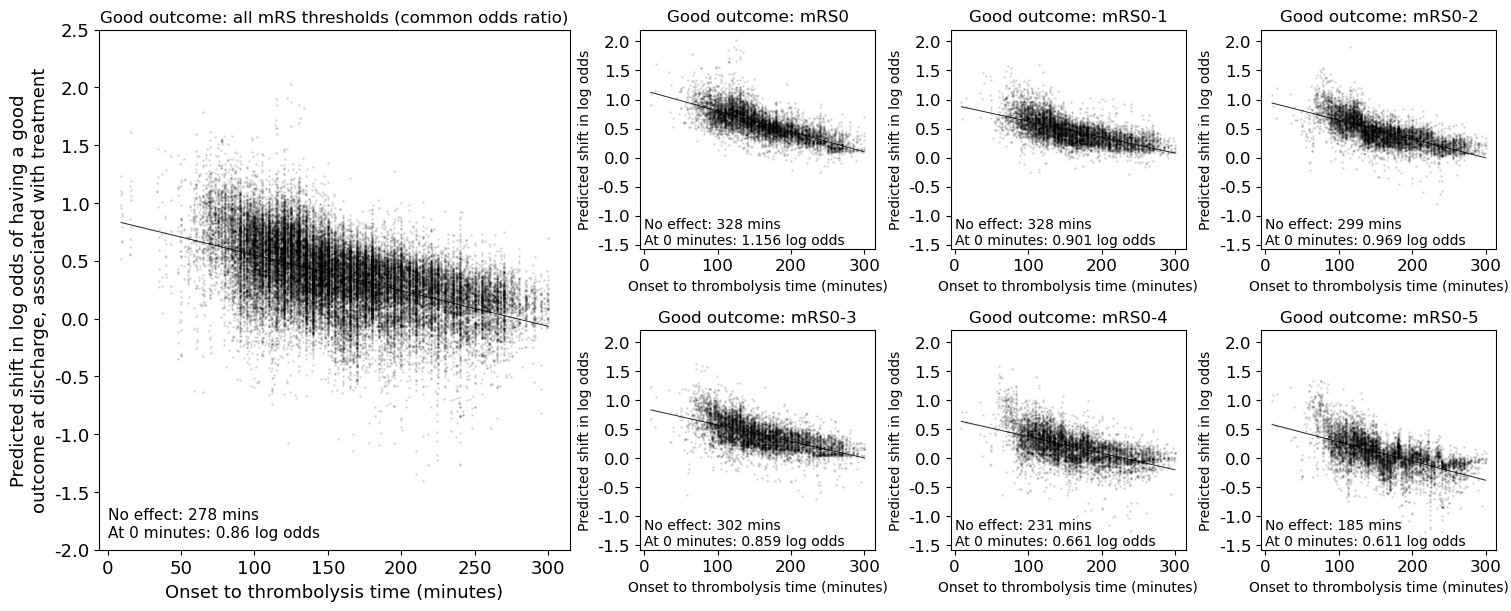

()

In [151]:
create_sns_mosaic_plot_for_paper(df_test_ivt_and_no_ivt_shap, 
                   300, "_nLVO_LVO", 
                   "[for patients with and without a large vessel occlusion]",
                   monochrome=True, total_shap_values=False)

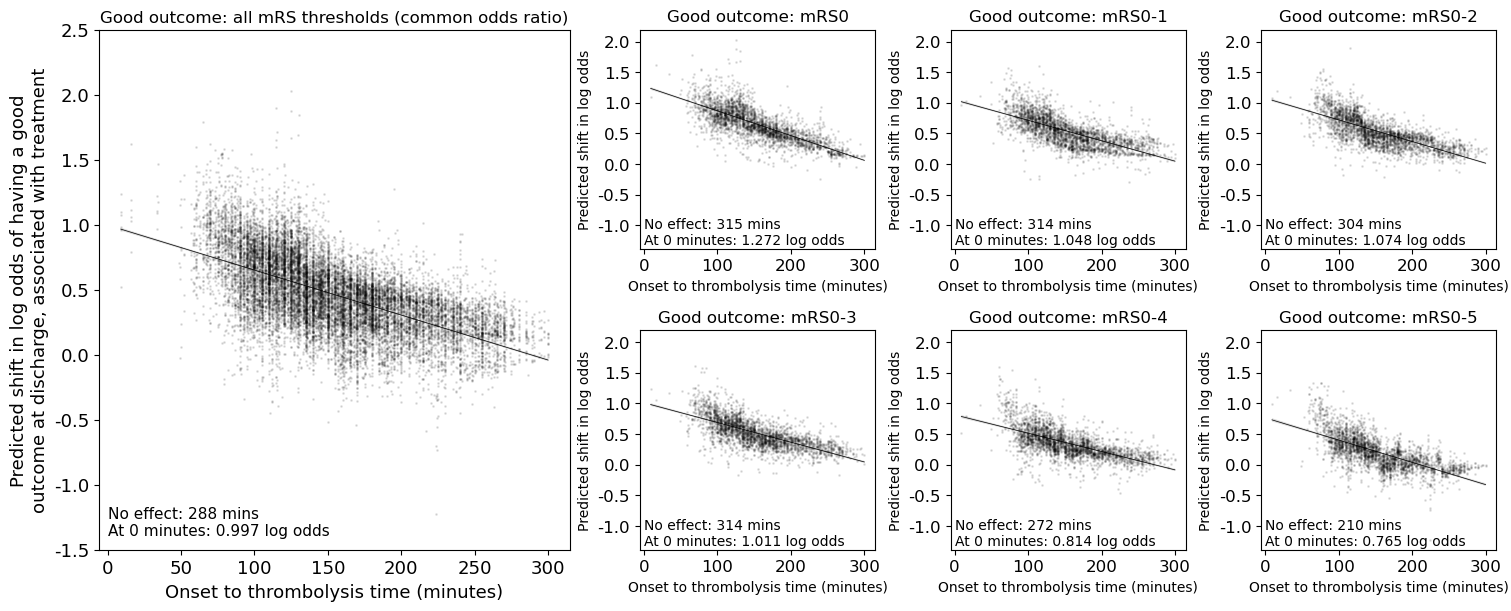

()

In [182]:
create_sns_mosaic_plot_for_paper(df_test_ivt_and_no_ivt_shap[mask_lvo], 
                   300, "_LVO", 
                   "[for patients with a large vessel occlusion]",
                   monochrome=True, total_shap_values=False)

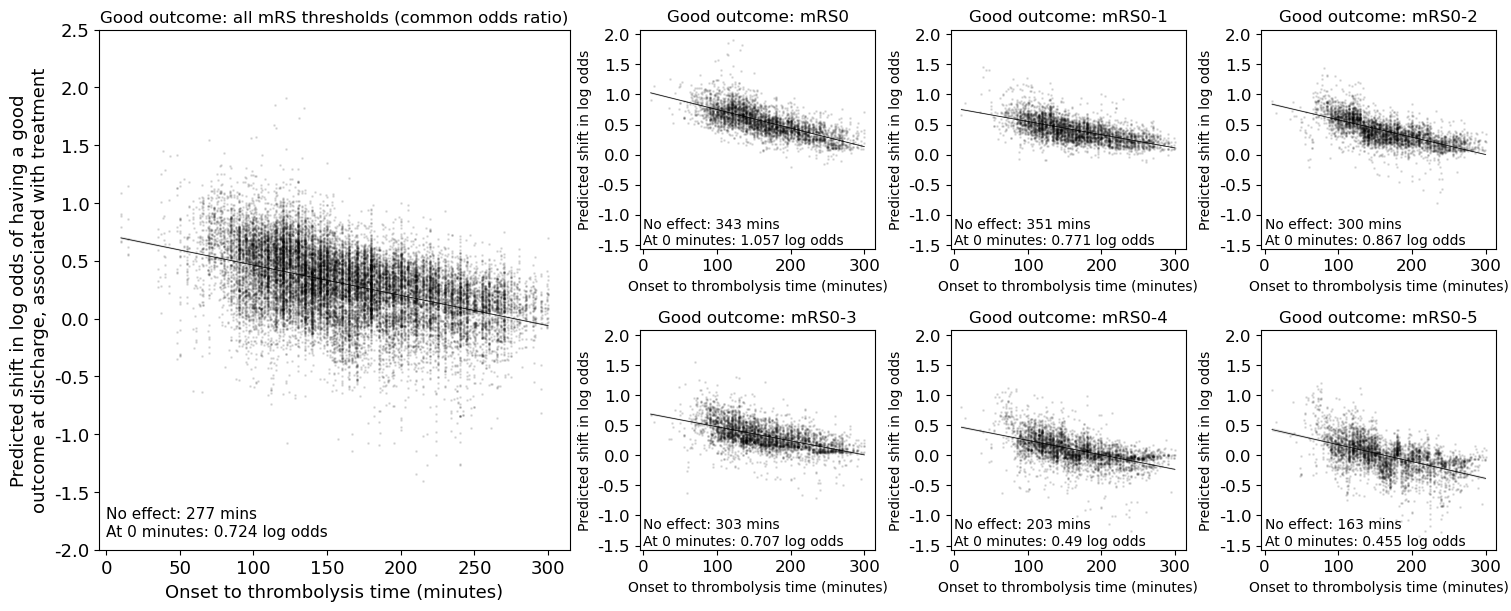

()

In [153]:
create_sns_mosaic_plot_for_paper(df_test_ivt_and_no_ivt_shap[mask_nlvo], 
                   300, "_nLVO", 
                   "[for patients without a large vessel occlusion]",
                   monochrome=True, total_shap_values=False)

Look at waterfall plot for a single patient, predicting whether better than each mRS threshold at discharge when had, and no had, treatment.

Use patient for the waterfall plots (mRS<=1) that spans the 0 SHAP value when have treatment or not (w/o treatment <0, with treatment >0).

In [154]:
t = 1
#instance = np.where(np.log(y_probs_threshold[t]) == np.log(y_probs_threshold[t]).max())[0][0]
mask_treatment_positive = np.log(y_probs_threshold[t]/(1-y_probs_threshold[t]))>0
mask_no_treatment_negative = np.log(y_probs_threshold_no_ivt[t]/(1-y_probs_threshold_no_ivt[t]))<0
mask = mask_treatment_positive * mask_no_treatment_negative
instance = np.where(mask == 1)[0][0]
instance

16

Patient 16, predicting if discharge disability <= mRS1, with treatment


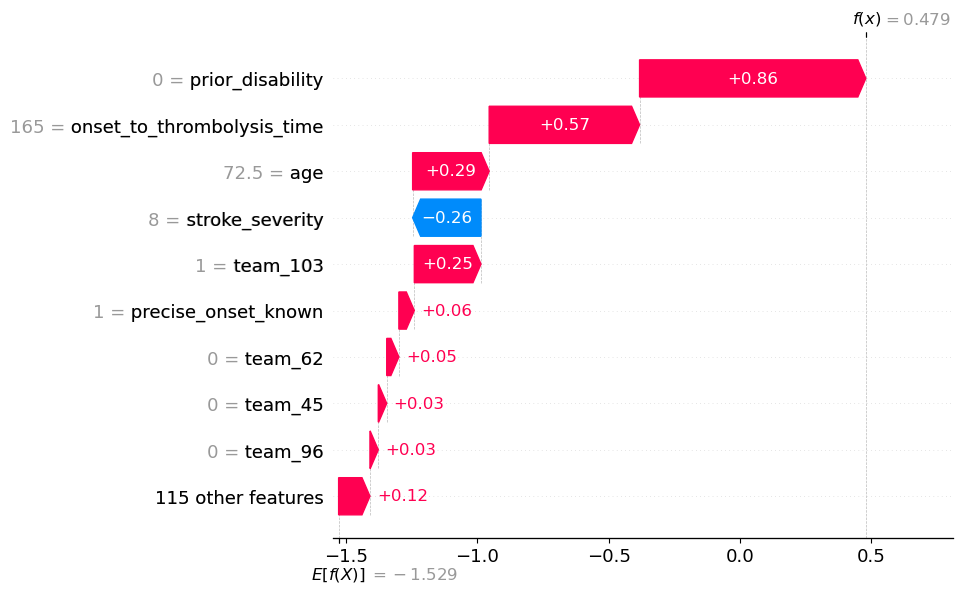

<Figure size 1500x1000 with 0 Axes>


Patient 16, predicting if discharge disability <= mRS1, no treatment


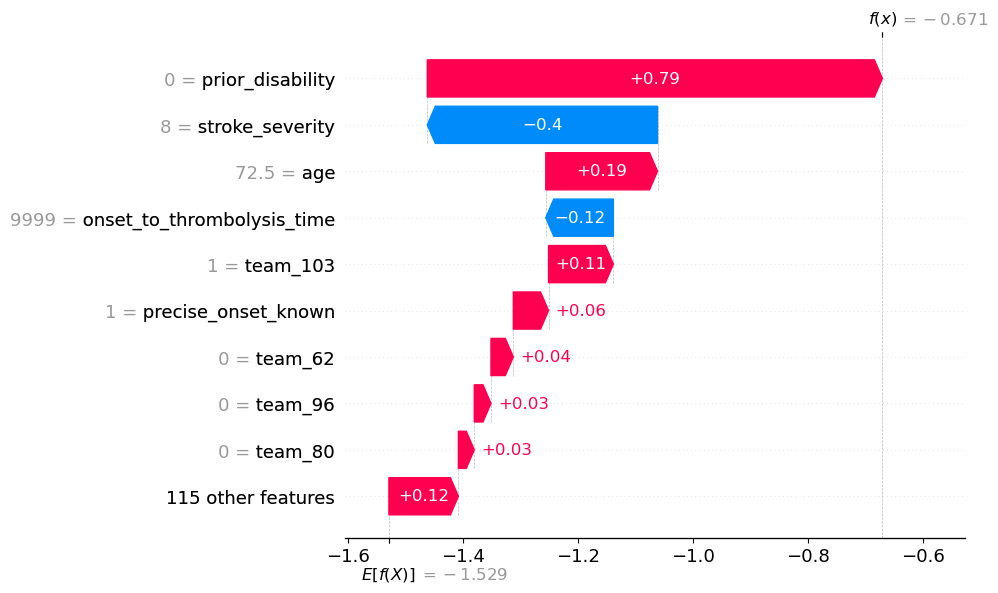

<Figure size 1500x1000 with 0 Axes>

In [155]:
print(f"Patient {instance}, predicting if discharge disability <= mRS{t}, with treatment")
shap.waterfall_plot(shap.Explanation(values=list_shap_values_extended[t].values[instance], 
                                base_values=list_shap_values_extended[t].base_values[instance], 
                                data=list_shap_values_extended[t].data[instance],  
                                feature_names=X_test.columns.tolist()), show=False)

filename = os.path.join(paths.image_save_path, (paths.notebook + paths.model_text + 
                        '_waterfall_plot_patient'+str(instance)+'_with_IVT.jpg'))

plt.figure(figsize=(15,10))
plt.tight_layout()
plt.savefig(filename, dpi=300)
plt.show()
print()
print(f"Patient {instance}, predicting if discharge disability <= mRS{t}, no treatment")
shap.waterfall_plot(shap.Explanation(values=list_shap_values_extended_no_ivt[t].values[instance], 
                                base_values=list_shap_values_extended_no_ivt[t].base_values[instance], 
                                data=list_shap_values_extended_no_ivt[t].data[instance],
                                feature_names=X_test.columns.tolist()), show=False)

filename = os.path.join(paths.image_save_path, (paths.notebook + paths.model_text + 
                        '_waterfall_plot_patient'+str(instance)+'_without_IVT.jpg'))

plt.figure(figsize=(15,10))
plt.tight_layout()
plt.savefig(filename, dpi=300)
plt.show()

For both nLVO and LVO patients, fitting multiple regression to patients treated within a max time (300 minutes).

Table of stats model for the regressions

In [156]:
mask_mrs1 = df_test_ivt_and_no_ivt_shap["mRS_threshold"]==1

In [157]:
X = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask_max_time]
y = df_test_ivt_and_no_ivt_shap["ivt_shap_ivt_improvement"][mask_max_time]
X = sm.add_constant(X)
multiple_reg_model = sm.OLS(y, X)
result = multiple_reg_model.fit() 
print(result.summary())


                               OLS Regression Results                               
Dep. Variable:     ivt_shap_ivt_improvement   R-squared:                       0.269
Model:                                  OLS   Adj. R-squared:                  0.269
Method:                       Least Squares   F-statistic:                 1.503e+04
Date:                      Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                              15:07:52   Log-Likelihood:                -3531.9
No. Observations:                     40776   AIC:                             7068.
Df Residuals:                         40774   BIC:                             7085.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

And for just the mRS0-1 threshold

In [158]:
X = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask_max_time*mask_mrs1]
y = df_test_ivt_and_no_ivt_shap["ivt_shap_ivt_improvement"][mask_max_time*mask_mrs1]
X = sm.add_constant(X)
multiple_reg_model = sm.OLS(y, X)
result = multiple_reg_model.fit() 
print(result.summary())

                               OLS Regression Results                               
Dep. Variable:     ivt_shap_ivt_improvement   R-squared:                       0.405
Model:                                  OLS   Adj. R-squared:                  0.405
Method:                       Least Squares   F-statistic:                     4632.
Date:                      Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                              15:07:52   Log-Likelihood:                 2295.1
No. Observations:                      6796   AIC:                            -4586.
Df Residuals:                          6794   BIC:                            -4573.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [159]:
#mask_max_time = (df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"] <= 
#                                                        max_treatment_time)
#mask_nlvo = df_test_ivt_and_no_ivt_shap["stroke_severity"] <= nonlvo_threshold
#mask = mask_nlvo * mask_max_time

X = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask_nlvo_time]
y = df_test_ivt_and_no_ivt_shap["ivt_shap_ivt_improvement"][mask_nlvo_time]
X = sm.add_constant(X)
multiple_reg_model = sm.OLS(y, X)
result = multiple_reg_model.fit() 
print(result.summary())


                               OLS Regression Results                               
Dep. Variable:     ivt_shap_ivt_improvement   R-squared:                       0.208
Model:                                  OLS   Adj. R-squared:                  0.208
Method:                       Least Squares   F-statistic:                     6201.
Date:                      Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                              15:07:52   Log-Likelihood:                -2416.7
No. Observations:                     23640   AIC:                             4837.
Df Residuals:                         23638   BIC:                             4853.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

And for just the mRS0-1 threshold

In [160]:
X = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask_nlvo_time*mask_mrs1]
y = df_test_ivt_and_no_ivt_shap["ivt_shap_ivt_improvement"][mask_nlvo_time*mask_mrs1]
X = sm.add_constant(X)
multiple_reg_model = sm.OLS(y, X)
result = multiple_reg_model.fit() 
print(result.summary())

                               OLS Regression Results                               
Dep. Variable:     ivt_shap_ivt_improvement   R-squared:                       0.370
Model:                                  OLS   Adj. R-squared:                  0.370
Method:                       Least Squares   F-statistic:                     2315.
Date:                      Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                              15:07:52   Log-Likelihood:                 1874.9
No. Observations:                      3940   AIC:                            -3746.
Df Residuals:                          3938   BIC:                            -3733.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [161]:
#mask_max_time = (df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"] <= 
#                                                        max_treatment_time)
#mask_lvo = df_test_ivt_and_no_ivt_shap["stroke_severity"] > nonlvo_threshold
#mask = mask_lvo * mask_max_time

X = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask_lvo_time]
y = df_test_ivt_and_no_ivt_shap["ivt_shap_ivt_improvement"][mask_lvo_time]
X = sm.add_constant(X)
multiple_reg_model = sm.OLS(y, X)
result = multiple_reg_model.fit() 
print(result.summary())


                               OLS Regression Results                               
Dep. Variable:     ivt_shap_ivt_improvement   R-squared:                       0.360
Model:                                  OLS   Adj. R-squared:                  0.360
Method:                       Least Squares   F-statistic:                     9638.
Date:                      Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                              15:07:52   Log-Likelihood:                 635.18
No. Observations:                     17136   AIC:                            -1266.
Df Residuals:                         17134   BIC:                            -1251.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

And for just the mRS0-1 threshold

In [162]:
X = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask_lvo_time*mask_mrs1]
y = df_test_ivt_and_no_ivt_shap["ivt_shap_ivt_improvement"][mask_lvo_time*mask_mrs1]
X = sm.add_constant(X)
multiple_reg_model = sm.OLS(y, X)
result = multiple_reg_model.fit() 
print(result.summary())

                               OLS Regression Results                               
Dep. Variable:     ivt_shap_ivt_improvement   R-squared:                       0.467
Model:                                  OLS   Adj. R-squared:                  0.467
Method:                       Least Squares   F-statistic:                     2504.
Date:                      Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                              15:07:52   Log-Likelihood:                 844.52
No. Observations:                      2856   AIC:                            -1685.
Df Residuals:                          2854   BIC:                            -1673.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

Repeat for using the full model prediction, rather than isolating the effect of thrombolysis using thrombolysis SHAP (as above)

In [173]:
print("**********")
print("Both nLVO and LVO and for the common odds ratio (all thresholds)")
X = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask_max_time]
y = df_test_ivt_and_no_ivt_shap["total_shap_ivt_improvement"][mask_max_time]
X = sm.add_constant(X)
multiple_reg_model = sm.OLS(y, X)
result = multiple_reg_model.fit() 
print(result.summary())
print()
print("**********")
print("Both nLVO and LVO and for just the mRS0-1 threshold")
X = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask_max_time*mask_mrs1]
y = df_test_ivt_and_no_ivt_shap["total_shap_ivt_improvement"][mask_max_time*mask_mrs1]
X = sm.add_constant(X)
multiple_reg_model = sm.OLS(y, X)
result = multiple_reg_model.fit() 
print(result.summary())
print()
print("**********")
print("Only nLVO and for the common odds ratio (all thresholds)")
X = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask_nlvo_time]
y = df_test_ivt_and_no_ivt_shap["total_shap_ivt_improvement"][mask_nlvo_time]
X = sm.add_constant(X)
multiple_reg_model = sm.OLS(y, X)
result = multiple_reg_model.fit()
print(result.summary()) 
print()
print("**********")
print("Only nLVO and for just the mRS0-1 threshold")
X = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask_nlvo_time*mask_mrs1]
y = df_test_ivt_and_no_ivt_shap["total_shap_ivt_improvement"][mask_nlvo_time*mask_mrs1]
X = sm.add_constant(X)
multiple_reg_model = sm.OLS(y, X)
result = multiple_reg_model.fit() 
print(result.summary())
print()
print("**********")
print("Only LVO and for the common odds ratio (all thresholds)")
X = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask_lvo_time]
y = df_test_ivt_and_no_ivt_shap["total_shap_ivt_improvement"][mask_lvo_time]
X = sm.add_constant(X)
multiple_reg_model = sm.OLS(y, X)
result = multiple_reg_model.fit() 
print(result.summary())
print()
print("**********")
print("Only LVO and for just the mRS0-1 threshold")
X = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask_lvo_time*mask_mrs1]
y = df_test_ivt_and_no_ivt_shap["total_shap_ivt_improvement"][mask_lvo_time*mask_mrs1]
X = sm.add_constant(X)
multiple_reg_model = sm.OLS(y, X)
result = multiple_reg_model.fit() 
print(result.summary())

**********
Both nLVO and LVO and for the common odds ratio (all thresholds)
                                OLS Regression Results                                
Dep. Variable:     total_shap_ivt_improvement   R-squared:                       0.135
Model:                                    OLS   Adj. R-squared:                  0.135
Method:                         Least Squares   F-statistic:                     6356.
Date:                        Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                                16:21:42   Log-Likelihood:                -26901.
No. Observations:                       40776   AIC:                         5.381e+04
Df Residuals:                           40774   BIC:                         5.382e+04
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                                 coef    std err      

In [163]:
xlabel = "Onset to thrombolysis time (minutes)"
ylabel = ("Estimated improvement associated with treatment"
          "\n(log odds improvements in being below mRS threshold)")


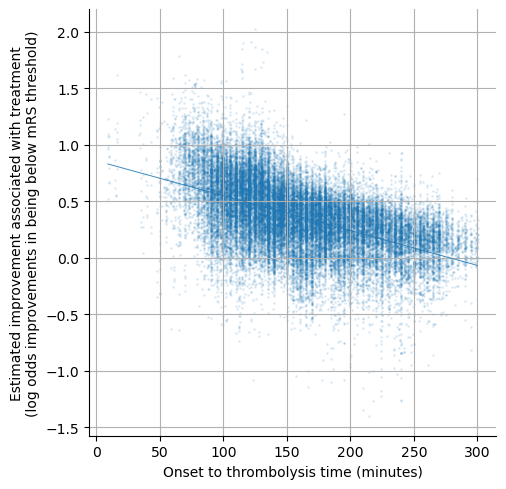

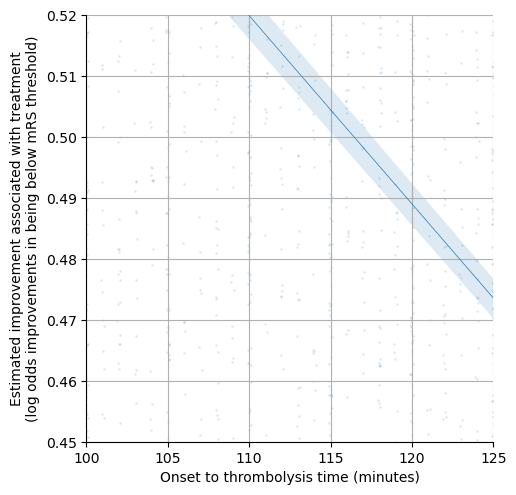

In [164]:
fig = sns.lmplot(x="onset_to_thrombolysis_time", y="ivt_shap_ivt_improvement", 
                 data=df_test_ivt_and_no_ivt_shap[mask_max_time], markers='o', x_jitter=0.1,
                 scatter_kws={"alpha": 0.1, "s": 1},
                 line_kws={"lw": 0.5});
fig.set_xlabels(xlabel)
fig.set_ylabels(ylabel)
#fig.set_titles("Full range (confidence limits not visible)",
#                  fontsize=24, fontdict={"weight": "bold"})
plt.grid()
plt.show();

fig = sns.lmplot(x="onset_to_thrombolysis_time", y="ivt_shap_ivt_improvement", 
                 data=df_test_ivt_and_no_ivt_shap[mask_max_time], markers='o', x_jitter=0.1,
                 scatter_kws={"alpha": 0.1, "s": 1},
                 line_kws={"lw": 0.5});
fig.set_xlabels(xlabel)
fig.set_ylabels(ylabel)
#fig.set_titles("Focused range (to view confidence limits)")
plt.ylim(0.45, 0.52)
plt.xlim(100, 125)
plt.grid()
plt.show();

Save data for use in notebook 110 (that fits a model to predict the predicted improvement due to IVT)

A dataframe, a row for each patient in the test set that has thrombolysis. Repeated for each mRS threshold.

Record some patient characteristics:
*  stroke severity
*  onset to IVT time (for when they had IVT)

Record some SHAP values (log-odds):
* their SHAP value for feature onset_to_thrombolysis_time when have thrombolysis
* their SHAP value for feature onset_to_thrombolysis_time when not have thrombolysis
* the difference between these SHAP values for the feature onset_to_thrombolysis_time
* their likelihood for good outcome (SHAP value f(x)) when have thrombolysis
* their likelihood for good outcome (SHAP value f(x)) when not have thrombolysis
* the difference between the SHAP values (f(x))

In [165]:
filename = os.path.join(paths.data_save_path, (paths.notebook + 
                        paths.model_text + "_improvement_due_to_ivt.csv"))
df_test_ivt_and_no_ivt_shap.to_csv(filename)

Duration to run notebook

In [166]:
str(datetime.timedelta(seconds=(time.time()-start_time)))

'0:00:28.279817'